# Predict Crimes in Vancouver - Initial Report and EDA

## Data and Problem Description

The goal of this project is to predict the probability of crimes in small spatial blocks of Vancouver and identify the contributing factors.

### Data Sources
- Crime statistics: https://vpd.ca/crime-statistics/. The downloaded data comes with a documentation:
    - The data is to be updated every Sunday morning, with a possible delay of 1 week.
    - The data begins in 2003.
    
    
- Census of population (demographic, social, and economic characteristics): https://www12.statcan.gc.ca/census-recensement/index-eng.cfm


- 2021 Census – Boundary files: https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-eng.cfm?year=21
    - Reference Guide: https://www150.statcan.gc.ca/n1/pub/92-160-g/92-160-g2021002-eng.htm


- Location of police stations: https://vpd.ca/community/community-policing-centres/

### Research Sources
[1] Hossain, S., Abtahee, A., Kashem, I., Hoque, M.M., Sarker, I.H. (2020). Crime Prediction Using Spatio-Temporal Data. In: Chaubey, N., Parikh, S., Amin, K. (eds) Computing Science, Communication and Security. COMS2 2020. Communications in Computer and Information Science, vol 1235. Springer, Singapore. https://doi.org/10.1007/978-981-15-6648-6_22

[2] Rotaru, V., Huang, Y., Li, T. et al. Event-level prediction of urban crime reveals a signature of enforcement bias in US cities. Nat Hum Behav 6, 1056–1068 (2022). https://doi.org/10.1038/s41562-022-01372-0

[3] CSV to Shapefile with pyshp: https://glenbambrick.com/2016/01/09/csv-to-shapefile-with-pyshp/

[4] Machine Learning with Datetime Feature Engineering: Predicting Healthcare Appointment No-Shows: https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96

[5] Fine tuning a classifier in scikit-learn: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

## Libraries and Functions

In [1]:
import pandas as pd
pd.options.display.max_columns = None  # display all dataframe columns in the notebook
import numpy as np
import math
from scipy import stats
import time  # compute execution time
import csv

# deal with coordinates
import geopandas as gpd
import shapefile
from shapely.geometry import shape, Point
from pyproj import CRS, Proj, Transformer

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, plot_tree, export_graphviz

# cynet
from cynet import cynet
from cynet.cynet import uNetworkModels as models
from viscynet import viscynet as vcn

# impute missing values
# explicitly require the experimental feature for the IterativeImputer
from sklearn.experimental import enable_iterative_imputer
# now we can import the IterativeImputer normally
from sklearn.impute import IterativeImputer, SimpleImputer

# transformers
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Bayesian optimization over hyperparameters
from skopt.searchcv import BayesSearchCV
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer

# metrics
from sklearn.metrics import precision_recall_curve, roc_auc_score, balanced_accuracy_score, average_precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# visualize trees
from IPython.display import Image  
from six import StringIO
import pydotplus, graphviz

# permutation importance
from sklearn.inspection import permutation_importance

# over/under sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# pipeline
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline 

# display pipelines
from sklearn import set_config
set_config(display="diagram")

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)  # set standard figure size
%matplotlib inline

# suppress warnings
import warnings
warnings.simplefilter(action='ignore')

In [2]:
## taken from [4]

# calculate specificity
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y):
    return (sum(y)/len(y))

def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_actual, (y_pred > thresh))
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    average_precision = average_precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    f1 = f1_score(y_actual, (y_pred > thresh))
    print('AUC:%.3f'%auc)
    print('balanced accuracy:%.3f'%balanced_accuracy)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('average precision:%.3f'%average_precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')

In [4]:
## taken from [5]

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

## EDA of Crime Data

### Read Crime Data

In [2]:
# read data
df = pd.read_csv('data/crimedata_csv_AllNeighbourhoods_AllYears.csv')
df.head()

TYPE  YEAR  MONTH  DAY  HOUR  MINUTE     HUNDRED_BLOCK  \
0  Theft from Vehicle  2017      2   21    22       0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017      3    8    12      45  1XX W GEORGIA ST   
2  Theft from Vehicle  2017      3   14    20       0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017      5    8     9      47  1XX W GEORGIA ST   
4  Theft from Vehicle  2017      5   17    13      18  1XX W GEORGIA ST   

               NEIGHBOURHOOD            X             Y  
0  Central Business District  491892.3455  5.458408e+06  
1  Central Business District  491892.3455  5.458408e+06  
2  Central Business District  491892.3455  5.458408e+06  
3  Central Business District  491892.3455  5.458408e+06  
4  Central Business District  491892.3455  5.458408e+06

In [3]:
# data size
df.shape

(842492, 10)

In [4]:
# data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842492 entries, 0 to 842491
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           842492 non-null  object 
 1   YEAR           842492 non-null  int64  
 2   MONTH          842492 non-null  int64  
 3   DAY            842492 non-null  int64  
 4   HOUR           842492 non-null  int64  
 5   MINUTE         842492 non-null  int64  
 6   HUNDRED_BLOCK  842480 non-null  object 
 7   NEIGHBOURHOOD  842350 non-null  object 
 8   X              842419 non-null  float64
 9   Y              842419 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 64.3+ MB


In [5]:
# number of missing values
df.isna().sum()

TYPE               0
YEAR               0
MONTH              0
DAY                0
HOUR               0
MINUTE             0
HUNDRED_BLOCK     12
NEIGHBOURHOOD    142
X                 73
Y                 73
dtype: int64

We have missing values in several columns. We will explore them later.

In [6]:
# create a new dataframe df_clean, which will be the cleaned version of the original dataframe df
df_clean = df.copy()

In [7]:
# transform column names to lower case
df_clean.columns = df_clean.columns.str.lower()

### Explore Categorical Columns

We look into `type` and `neighbourhood`.

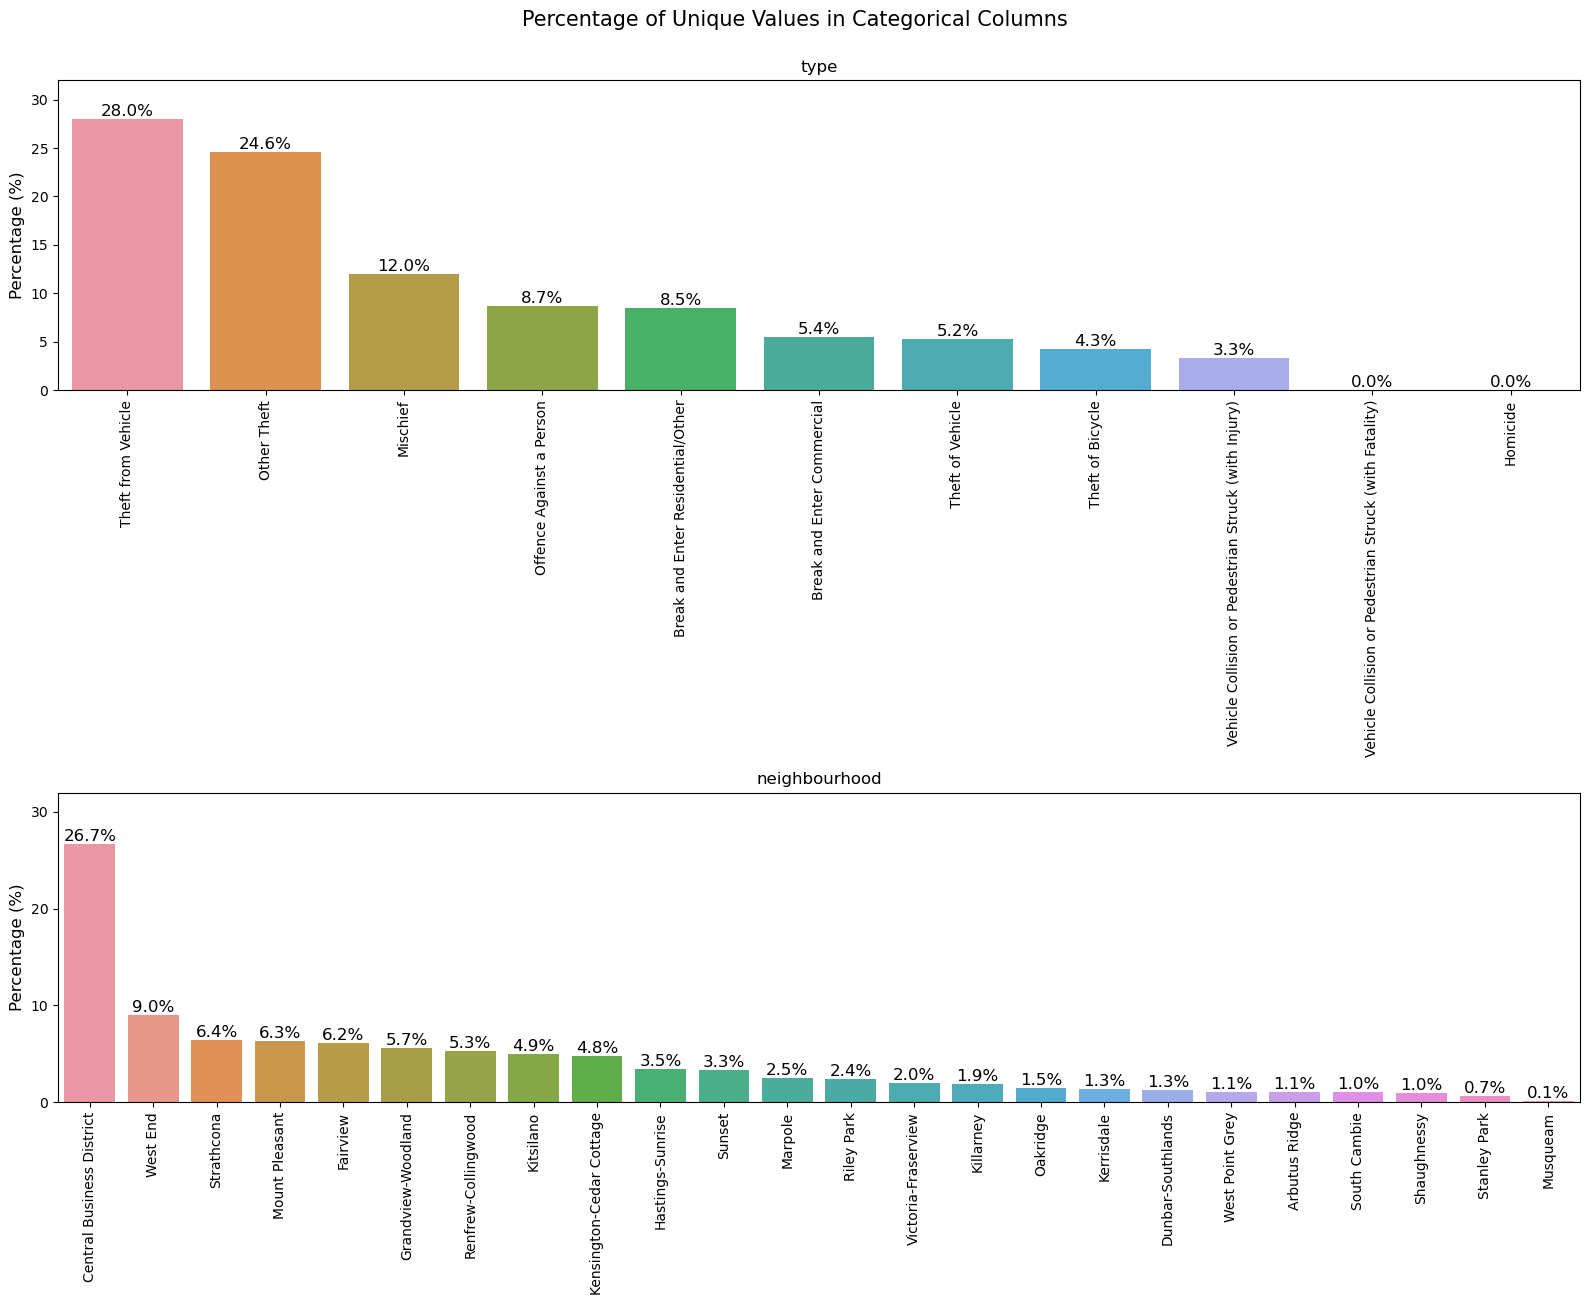

In [8]:
# Calculate and plot (bar plot) the percentage of unique values in categorical columns.

i=0
n_cols = 2

fig, ax = plt.subplots(n_cols, 1, figsize=(16,13))
fig.suptitle('Percentage of Unique Values in Categorical Columns', fontsize=15, y=1.)

for col in ['type','neighbourhood']:
    df_col = df_clean[col].value_counts(normalize=True).mul(100).rename('Percentage (%)').reset_index()
 
    g = sns.barplot(x='index', y='Percentage (%)', data=df_col, ax=ax[i])
    
    g.set_xticks(g.get_xticks(), fontsize = 12)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = 90)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    g.set_title(col, fontsize=12)
    g.set_xlabel('')
    g.set_ylabel('Percentage (%)', fontsize = 12)
    
    # add percentages as text to the bars
    for container in g.containers:
        g.bar_label(container, fmt='%.1f%%', fontsize=12)
    bottom, upper = g.get_ylim()
    g.set_ylim(bottom, upper+2)
    plt.subplots_adjust(hspace=5)
    
    i=i+1

fig.tight_layout()

- There are 11 types of crime in the dataset.
- `Theft from Vehicle` and `Other Theft` are the most common reported crimes in Vancouver.
- `Homicide` and `Vehicle Collision or Pedestrian Struck (with Fatality)` are the least common crimes.
- `Central Business District` has by far the highest amount of reported crimes, whereas `Musqueam` has the lowest amount of reported crimes.

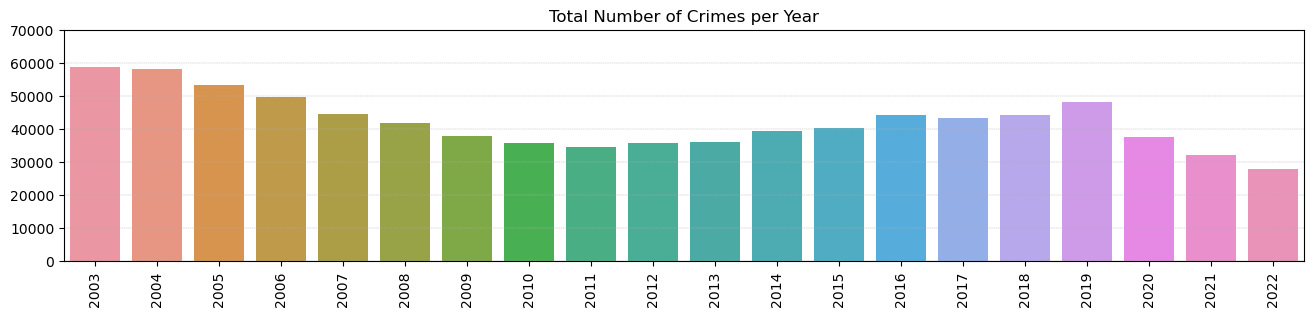

In [10]:
# Calculate and plot (count plot) the total number of crimes per year.

fig, ax = plt.subplots(figsize=(16,3))
g = sns.countplot(x='year', data=df_clean, ax=ax)
g.set_xticks(g.get_xticks(), fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
g.set_yticks(g.get_yticks(), fontsize = 12)
g.set_title('Total Number of Crimes per Year', fontsize=12)
g.set_xlabel('')
g.set_ylabel('')
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.3);

- The total number of crimes has a decreasing trend over time.
- 2003 has the highest number of crimes.
- There was a period of an incline of crimes from around 2013 to 2019.

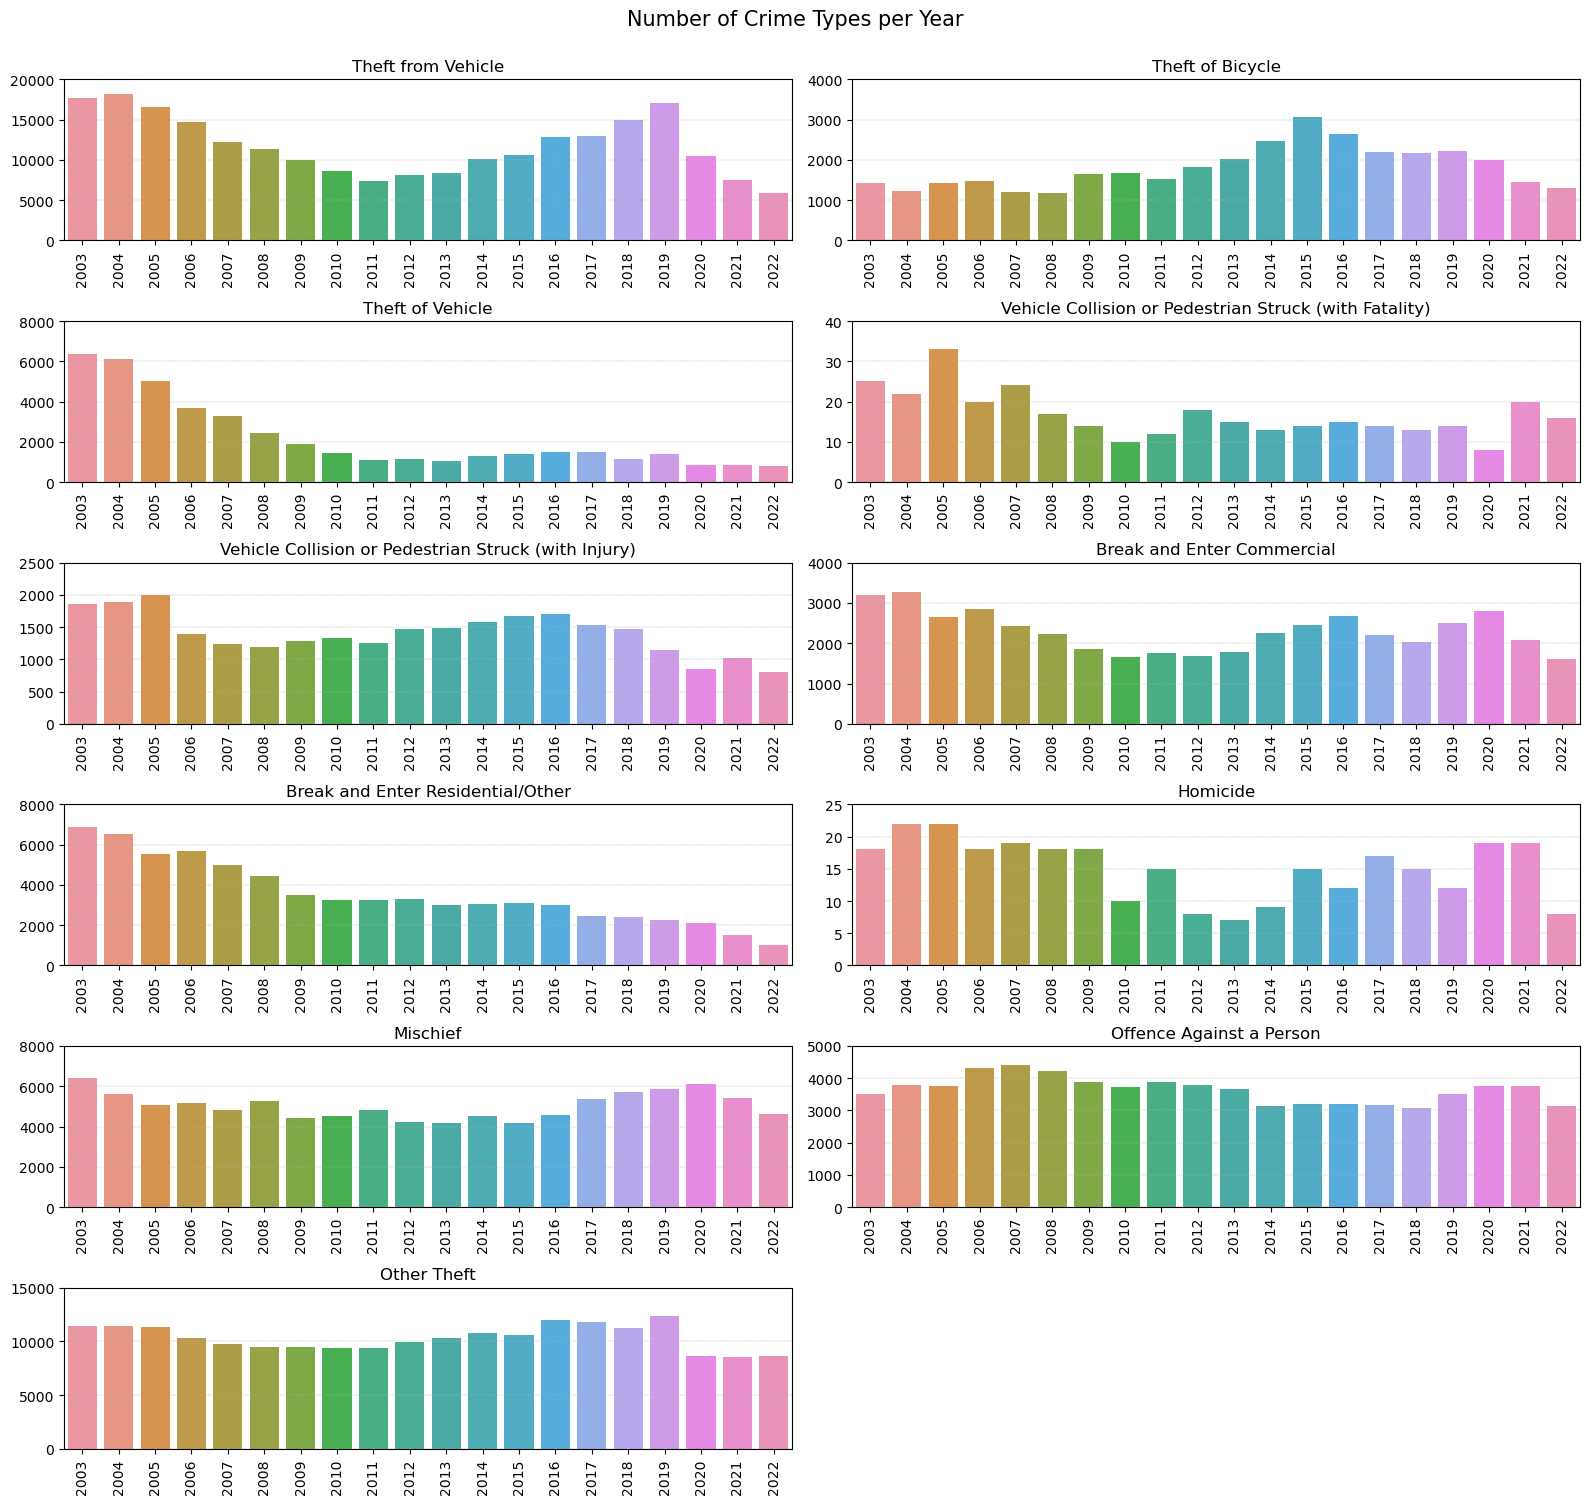

In [11]:
# Calculate and plot (count plot) the number of crime types per year.

i=0
n_cols = 2

fig, ax = plt.subplots(math.ceil((df_clean['type'].nunique()/n_cols)), n_cols, figsize=(16,15))
fig.suptitle('Number of Crime Types per Year', fontsize=15, y=1.)

for crime_type in df_clean['type'].unique():
    g = sns.countplot(x='year', data=df_clean[df_clean['type']==crime_type], ax=ax[i//n_cols,i%n_cols])
    
    g.set_xticks(g.get_xticks(), fontsize = 12)
    ax[i//n_cols,i%n_cols].set_xticklabels(ax[i//n_cols,i%n_cols].get_xticklabels(), rotation = 90)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    g.set_title(crime_type, fontsize=12)
    g.set_xlabel('')
    g.set_ylabel('')
    ax[i//n_cols,i%n_cols].grid(axis = 'y', linestyle = '--', linewidth = 0.3)
    
    i=i+1

# remove the extra, empty last subplot (if applicable)
if df_clean['type'].nunique()%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()
    
fig.tight_layout()

Different crime types have different trends:
- `Theft of Vehicle` declines at a quite steep rate until 2011, and stays relatively low onwards.
- `Theft of Bicycle` has the highest counts in 2015. While all the other crime types start with almost highest numbers in 2003-2005, `Theft of Bicycle` starts with almost lowest numbers.
- Two crime types had a significant incline:
    - `Theft from Vehicle` from around 2013 to 2019. 
    - `Theft of Bicycle` from around 2011 to 2015.
-`Homocide` had a significant drop from 2021 to 2022.

In [12]:
# calculate the percentage of change in the number of crime types per year compared to the year 2003

reference_2003 = df_clean[df_clean['year']==2003].groupby(['type'])['year'].count()
change_to_reference = pd.DataFrame()

for year in df_clean[~(df_clean['year']==2003)]['year'].unique():
    count_year = df_clean[df_clean['year']==year].groupby(['type'])['year'].count()
    change_year = (count_year.subtract(reference_2003, fill_value=0)*100.).divide(reference_2003, fill_value=0)
    change_year = change_year.rename(year)
    change_to_reference = change_to_reference.append(change_year.to_frame().transpose())
    
change_to_reference.sort_index().head()

type  Break and Enter Commercial  Break and Enter Residential/Other  \
2004                    2.564905                          -5.084253   
2005                  -17.453863                         -19.552586   
2006                  -11.010322                         -17.606043   
2007                  -23.834845                         -27.425915   
2008                  -30.403503                         -35.676932   

type   Homicide   Mischief  Offence Against a Person  Other Theft  \
2004  22.222222 -12.366938                  8.514286     0.096263   
2005  22.222222 -20.742016                  7.285714    -0.603833   
2006   0.000000 -18.910457                 23.485714    -9.862606   
2007   5.555556 -24.655604                 25.628571   -14.894548   
2008   0.000000 -17.485911                 20.314286   -17.169861   

type  Theft from Vehicle  Theft of Bicycle  Theft of Vehicle  \
2004            2.581154        -13.258110         -4.103128   
2005           -6.706492         -0.141044        -20.924383   
2006          -16.986023          3.455571        -42.131740   
2007          -31.092200        -15.162200        -48.058481   
2008          -36.344680        -17.066291        -61.987109   

type  Vehicle Collision or Pedestrian Struck (with Fatality)  \
2004                                              -12.0        
2005                                               32.0        
2006                                              -20.0        
2007                                               -4.0        
2008                                              -32.0        

type  Vehicle Collision or Pedestrian Struck (with Injury)  
2004                                           1.939655     
2005                                           7.920259     
2006                                         -25.215517     
2007                                         -33.243534     
2008                                         -36.099138

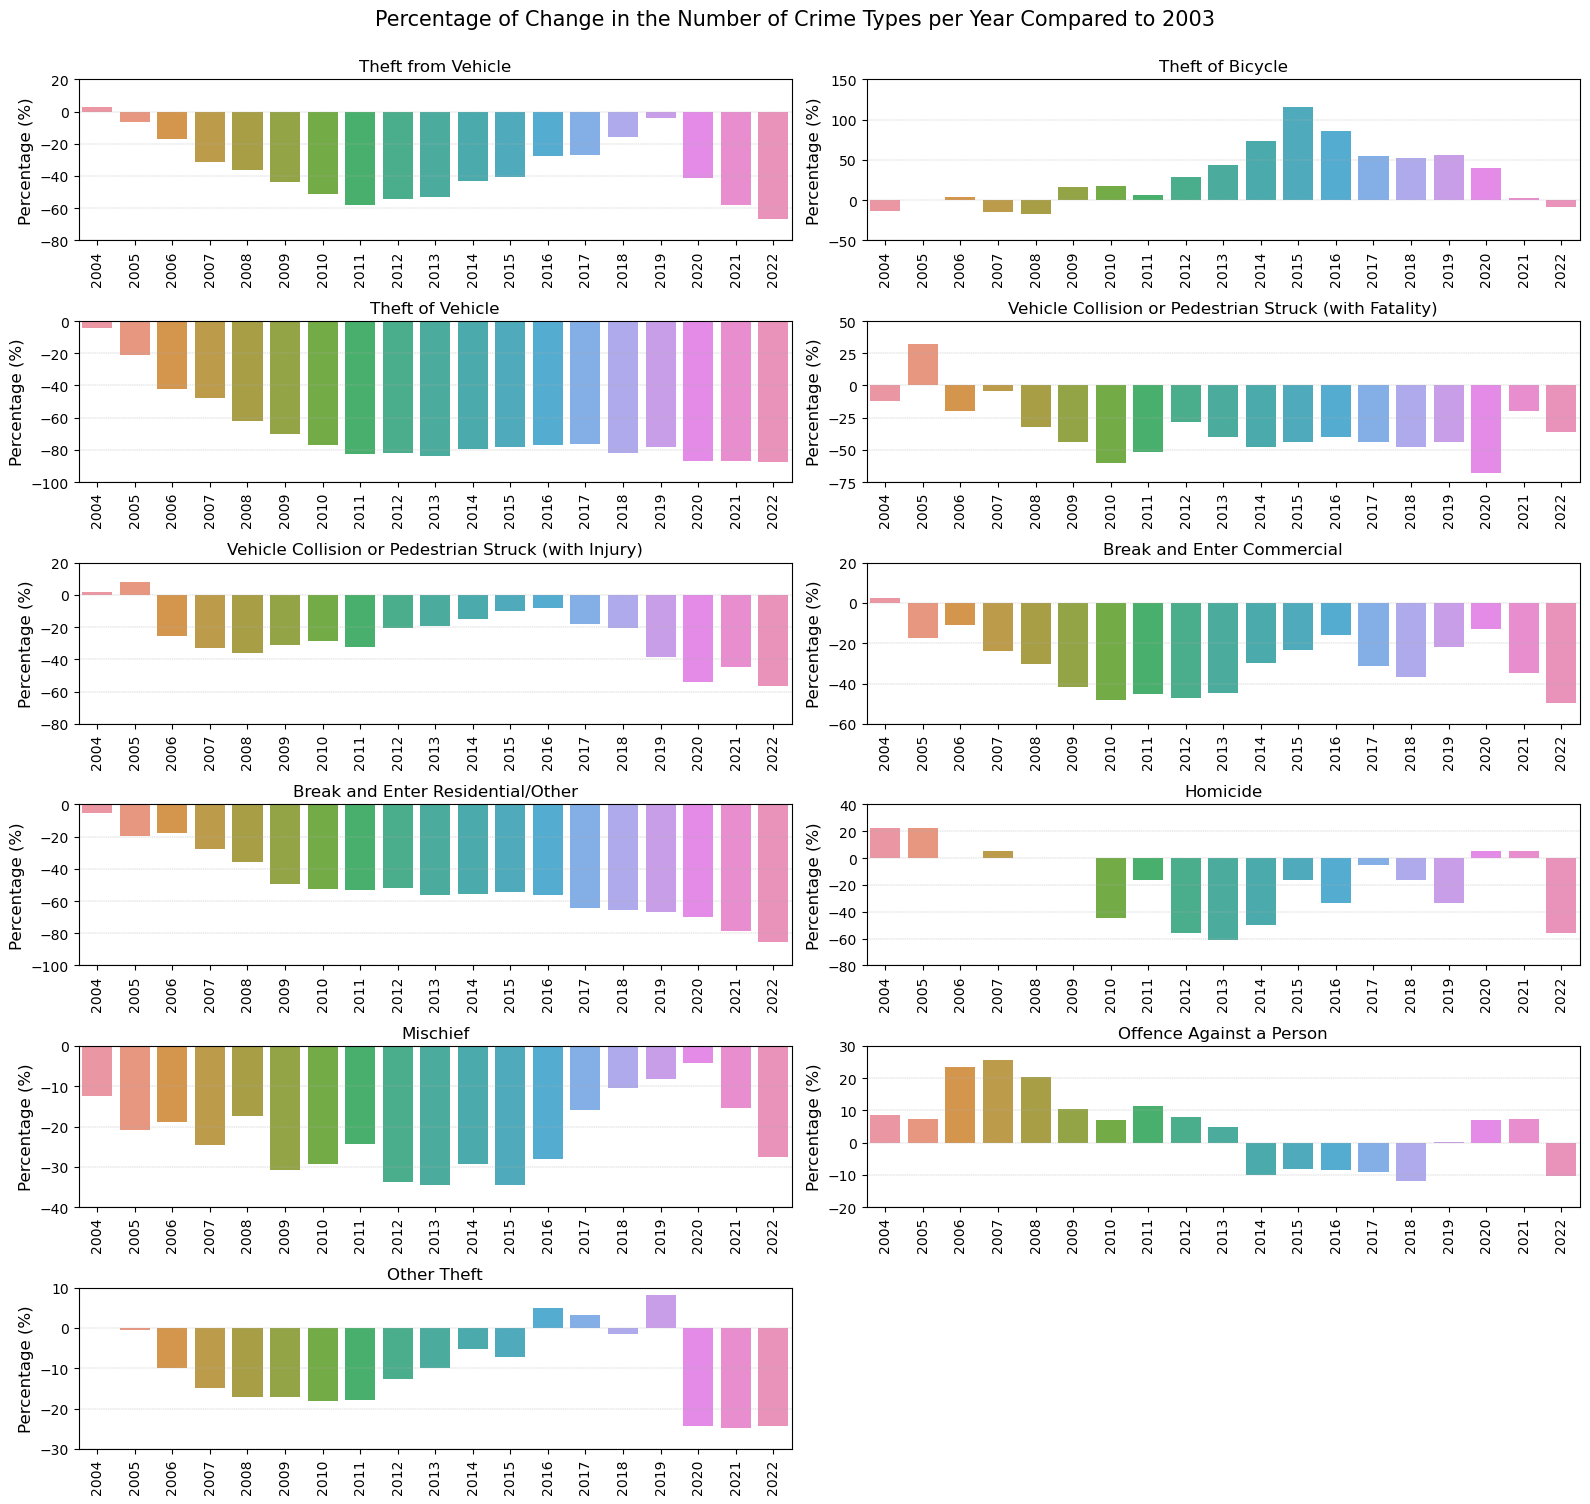

In [13]:
# Plot (bar plot) the percentage of change in the number of crime types per year compared to the year 2003.

i=0
n_cols = 2

fig, ax = plt.subplots(math.ceil((change_to_reference.shape[1]/n_cols)), n_cols, figsize=(16,15))
fig.suptitle('Percentage of Change in the Number of Crime Types per Year Compared to 2003', fontsize=15, y=1.)

for crime_type in df_clean['type'].unique():
    g = sns.barplot(x=change_to_reference.index, y=change_to_reference[crime_type], data=change_to_reference, ax=ax[i//n_cols,i%n_cols])
    
    g.set_xticks(g.get_xticks(), fontsize = 12)
    ax[i//n_cols,i%n_cols].set_xticklabels(ax[i//n_cols,i%n_cols].get_xticklabels(), rotation = 90)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    g.set_title(crime_type, fontsize=12)
    g.set_xlabel('')
    g.set_ylabel('Percentage (%)', fontsize = 12)
    ax[i//n_cols,i%n_cols].grid(axis = 'y', linestyle = '--', linewidth = 0.3)
    
    i=i+1

# remove the extra, empty last subplot (if applicable)
if change_to_reference.shape[1]%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()
    
fig.tight_layout()

- `Theft of Vehicle` has the best improvement since 2003, followed by `Break and Enter Residential/Other`.
- `Theft of Bicycle` has the worst development since 2003.

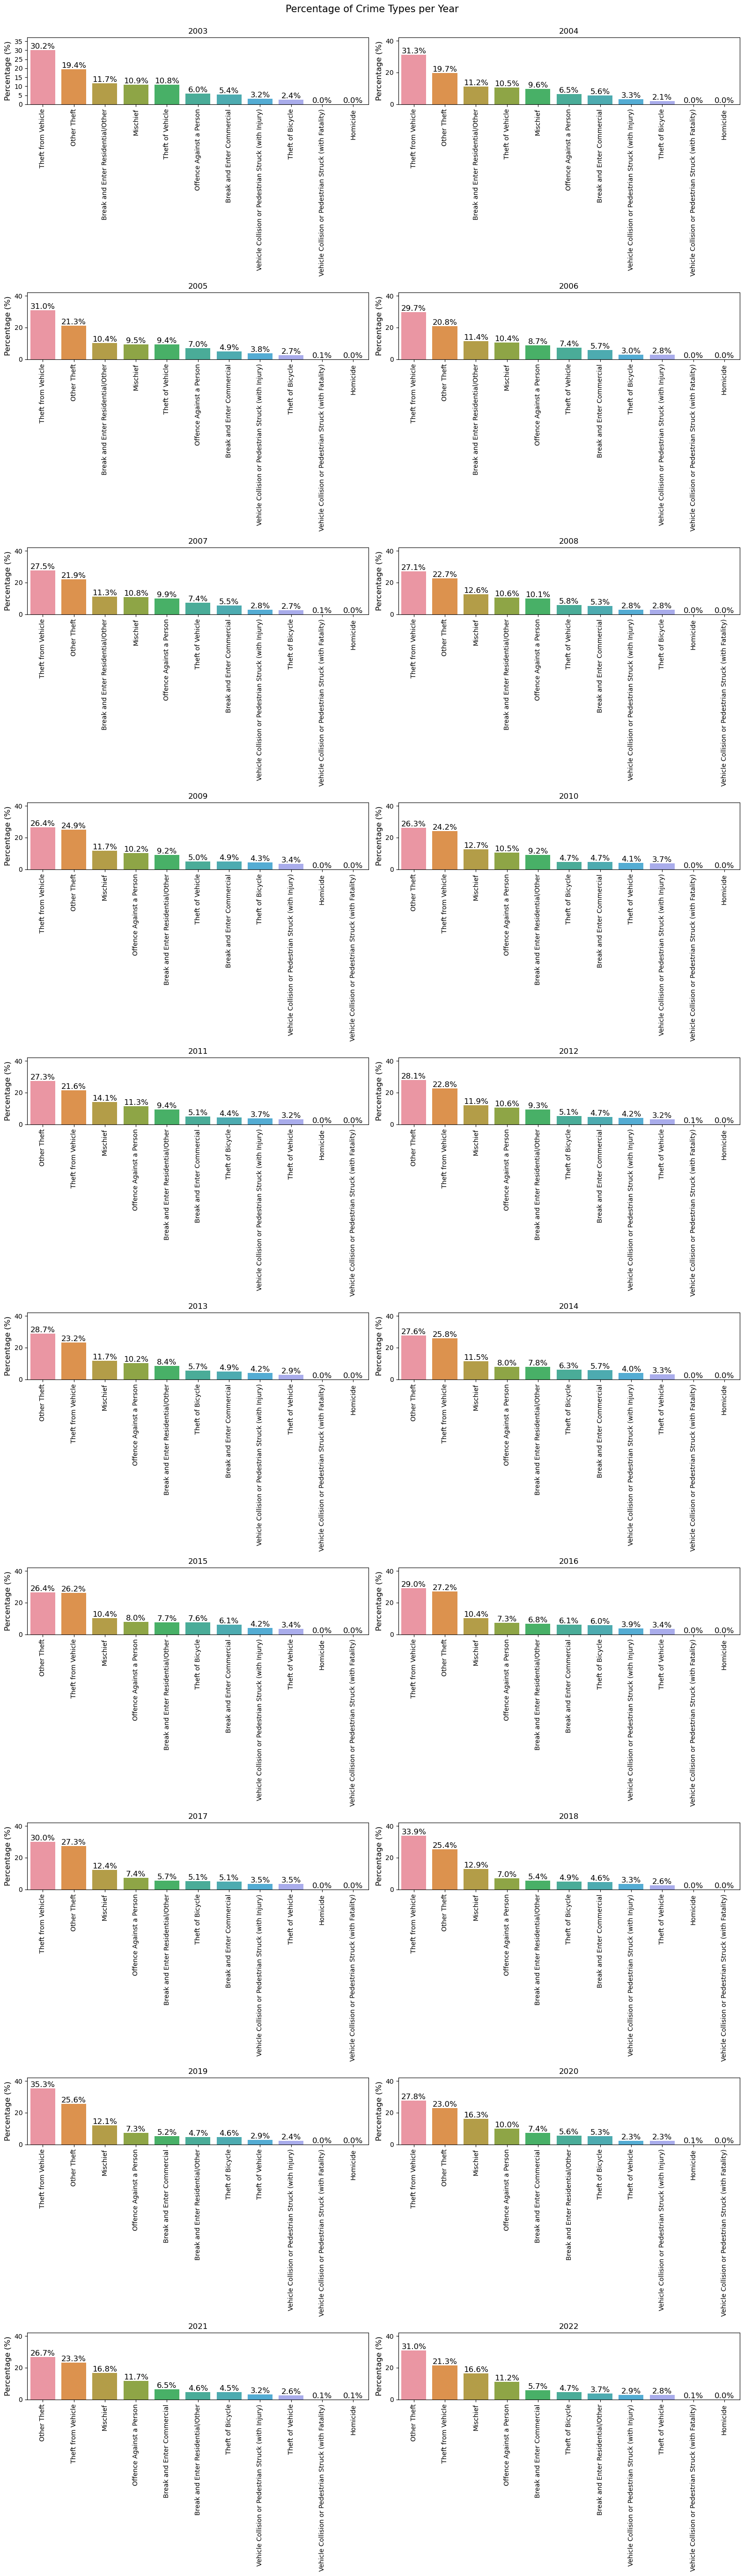

In [14]:
# Calculate and plot (bar plot) the percentage of crime types per year.

i=0
n_cols = 2

fig, ax = plt.subplots(math.ceil((df_clean['year'].nunique()/n_cols)), n_cols, figsize=(16,55))
fig.suptitle('Percentage of Crime Types per Year', fontsize=15, y=1.)

for year in np.sort(df_clean['year'].unique()):
    df_col = df_clean[df_clean['year']==year]['type'].value_counts(normalize=True).mul(100).rename('Percentage (%)').reset_index()
 
    g = sns.barplot(x='index', y='Percentage (%)', data=df_col, ax=ax[i//n_cols,i%n_cols])
    
    g.set_xticks(g.get_xticks(), fontsize = 12)
    ax[i//n_cols,i%n_cols].set_xticklabels(ax[i//n_cols,i%n_cols].get_xticklabels(), rotation = 90)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    g.set_title(year, fontsize=12)
    g.set_xlabel('')
    g.set_ylabel('Percentage (%)', fontsize = 12)
    
    # add percentages as text to the bars
    for container in g.containers:
        g.bar_label(container, fmt='%.1f%%', fontsize=12)
    bottom, upper = g.get_ylim()
    g.set_ylim(bottom, upper+2)
    plt.subplots_adjust(hspace=5)
    
    i=i+1

# remove the extra, empty last subplot (if applicable)
if df_clean['year'].nunique()%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()
    
fig.tight_layout()

Among the years 2003 to 2022, the percentage of crime types seems similar.


### Explore Numerical Columns

In [15]:
# descriptive statistics of our data
df_clean.describe()

year          month            day           hour  \
count  842492.000000  842492.000000  842492.000000  842492.000000   
mean     2011.792821       6.511602      15.386627      12.341404   
std         5.891405       3.394137       8.753494       7.460096   
min      2003.000000       1.000000       1.000000       0.000000   
25%      2006.000000       4.000000       8.000000       7.000000   
50%      2012.000000       7.000000      15.000000      14.000000   
75%      2017.000000       9.000000      23.000000      18.000000   
max      2022.000000      12.000000      31.000000      23.000000   

              minute              x             y  
count  842492.000000  842419.000000  8.424190e+05  
mean       15.781385  449438.858819  4.982715e+06  
std        18.333309  138660.734523  1.537014e+06  
min         0.000000       0.000000  0.000000e+00  
25%         0.000000  490184.310100  5.454215e+06  
50%         5.000000  491562.892700  5.457159e+06  
75%        30.000000  493384.492800  5.458718e+06  
max        59.000000  511303.000000  5.512579e+06

`x` and `y` have 0 values, which are wrong/missing coordinates. Let's analyze them.

#### Analyze Wrong/Missing Coordinates

In [16]:
# minimum "correct" x-coordinate
x_min = df_clean[df_clean['x']>0]['x'].min()
x_min

388373.0

In [17]:
# number of missing coordinates
df_clean[df_clean['x']<x_min]['x'].value_counts()

0.0    73194
Name: x, dtype: int64

There are 73,194 missing coordinates.

In [18]:
# percentage of missing coordinates
100.*len(df_clean[df_clean['x']<x_min]['x'])/df_clean.shape[0]

8.68779762893891

The missing coordinates form almost 9% of the data. Let's look at them closer to see if other location information is available for those.

In [24]:
# first few rows of the dataframe for missing coordinates
df_clean[df_clean['x']<x_min].head()

type  year  month  day  \
259835  Vehicle Collision or Pedestrian Struck (with I...  2019      9    3   
259836  Vehicle Collision or Pedestrian Struck (with I...  2021      3   31   
259837  Vehicle Collision or Pedestrian Struck (with I...  2022      2   26   
397468                                           Homicide  2018     12   22   
397469                                           Homicide  2017      2    1   

        hour  minute              hundred_block neighbourhood    x    y  
259835    21      26             99XXXX UNKNOWN           NaN  0.0  0.0  
259836    11      34             99XXXX UNKNOWN           NaN  0.0  0.0  
259837     5      25             99XXXX UNKNOWN           NaN  0.0  0.0  
397468     0       0  OFFSET TO PROTECT PRIVACY    Strathcona  0.0  0.0  
397469     0       0  OFFSET TO PROTECT PRIVACY  Stanley Park  0.0  0.0

In [20]:
# crime types at missing coordinates
df_clean[df_clean['x']<x_min]['type'].value_counts()

Offence Against a Person                                72890
Homicide                                                  301
Vehicle Collision or Pedestrian Struck (with Injury)        3
Name: type, dtype: int64

As stated in the provided crime data documentation,
> Locations for reported incidents involving Offences Against a Person have been deliberately randomized to several blocks and offset to an intersection. No time or street location name will be provided for these offences.

In [21]:
# hundred_block at missing coordinates
df_clean[df_clean['x']<x_min]['hundred_block'].value_counts()

OFFSET TO PROTECT PRIVACY    73191
99XXXX UNKNOWN                   3
Name: hundred_block, dtype: int64

As stated in the provided crime data documentation,
> Coordinates data for records with “Offset to Protect Privacy” was not disclosed to provide privacy protection.

In [22]:
# neighbourhood at missing coordinates
df_clean[df_clean['x']<x_min]['neighbourhood'].unique()

array([nan, 'Strathcona', 'Stanley Park', 'West End',
       'Central Business District', 'Mount Pleasant',
       'Grandview-Woodland', 'Hastings-Sunrise', 'Renfrew-Collingwood',
       'Marpole', 'Sunset', 'Kensington-Cedar Cottage',
       'Victoria-Fraserview', 'Killarney', 'West Point Grey', 'Kitsilano',
       'Dunbar-Southlands', 'Kerrisdale', 'Shaughnessy', 'Fairview',
       'Oakridge', 'South Cambie', 'Riley Park', 'Musqueam',
       'Arbutus Ridge'], dtype=object)

In [29]:
# NaN neighbourhood at missing coordinates
df_clean[df_clean['x']<x_min]['neighbourhood'].isna().sum()

49

Most of the missing coordinates do have a neighborhood entry; except for 49 rows:

In [23]:
df_clean[(df_clean['x']<x_min) & (df_clean['neighbourhood'].isna())].head()

type  year  month  day  \
259835  Vehicle Collision or Pedestrian Struck (with I...  2019      9    3   
259836  Vehicle Collision or Pedestrian Struck (with I...  2021      3   31   
259837  Vehicle Collision or Pedestrian Struck (with I...  2022      2   26   
397503                                           Homicide  2018      4   26   
397768                                           Homicide  2016      3   10   

        hour  minute              hundred_block neighbourhood    x    y  
259835    21      26             99XXXX UNKNOWN           NaN  0.0  0.0  
259836    11      34             99XXXX UNKNOWN           NaN  0.0  0.0  
259837     5      25             99XXXX UNKNOWN           NaN  0.0  0.0  
397503     0       0  OFFSET TO PROTECT PRIVACY           NaN  0.0  0.0  
397768     0       0  OFFSET TO PROTECT PRIVACY           NaN  0.0  0.0

As stated in the provided crime data documentation,
> X NK_LOC ST is default location value used for incidents with unknown location and is geolocated to 312 Main Street.

Let's look at those:

In [24]:
df_clean[df_clean['hundred_block'].str.contains('NK_LOC', na=False)]['hundred_block'].value_counts()

X NK_LOC ST                             6232
X NK_LOC ST "SQUAMISH"                     2
X NK_LOC ST "WATER"                        2
X NK_LOC ST "4100 BLOCK VANNESS AVE"       1
X NK_LOC ST "UBC"                          1
X  NK_LOC ST                               1
Name: hundred_block, dtype: int64

6239 entries have a default location value.

#### Explore Dates

In [25]:
# create datetime
df_clean['date'] = pd.to_datetime(df_clean[['year','month','day']])
df_clean.head()

type  year  month  day  hour  minute     hundred_block  \
0  Theft from Vehicle  2017      2   21    22       0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017      3    8    12      45  1XX W GEORGIA ST   
2  Theft from Vehicle  2017      3   14    20       0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017      5    8     9      47  1XX W GEORGIA ST   
4  Theft from Vehicle  2017      5   17    13      18  1XX W GEORGIA ST   

               neighbourhood            x             y       date  
0  Central Business District  491892.3455  5.458408e+06 2017-02-21  
1  Central Business District  491892.3455  5.458408e+06 2017-03-08  
2  Central Business District  491892.3455  5.458408e+06 2017-03-14  
3  Central Business District  491892.3455  5.458408e+06 2017-05-08  
4  Central Business District  491892.3455  5.458408e+06 2017-05-17

In [26]:
# get weekday
df_clean['weekday'] = df_clean['date'].dt.day_name()
df_clean.sort_values(by=['date']).head()

type  year  month  day  \
257617  Vehicle Collision or Pedestrian Struck (with I...  2003      1    1   
751563                                        Other Theft  2003      1    1   
478126                                           Mischief  2003      1    1   
446547                                           Mischief  2003      1    1   
208473                                   Theft of Vehicle  2003      1    1   

        hour  minute           hundred_block              neighbourhood  \
257617    17      25  49XX BLOCK VICTORIA DR   Kensington-Cedar Cottage   
751563    10       0         9X E CORDOVA ST  Central Business District   
478126    13      15          7XX MALKIN AVE                 Strathcona   
446547    11       0          35XX FRASER ST                 Riley Park   
208473     5      30        10XX MAINLAND ST  Central Business District   

                  x             y       date    weekday  
257617  495266.0000  5.454098e+06 2003-01-01  Wednesday  
751563  492557.9283  5.458853e+06 2003-01-01  Wednesday  
478126  493595.9908  5.458007e+06 2003-01-01  Wednesday  
446547  493447.8835  5.455621e+06 2003-01-01  Wednesday  
208473  491343.9409  5.458206e+06 2003-01-01  Wednesday

As stated in the provided crime data documentation,
> No time information will be provided for Offences Against a Person crime type.

In [28]:
df_clean[df_clean['type']=='Offence Against a Person'][['hour','minute']].value_counts()

hour  minute
0     0         72890
dtype: int64

As we can see, hour and minute are all set to zero for this crime type.

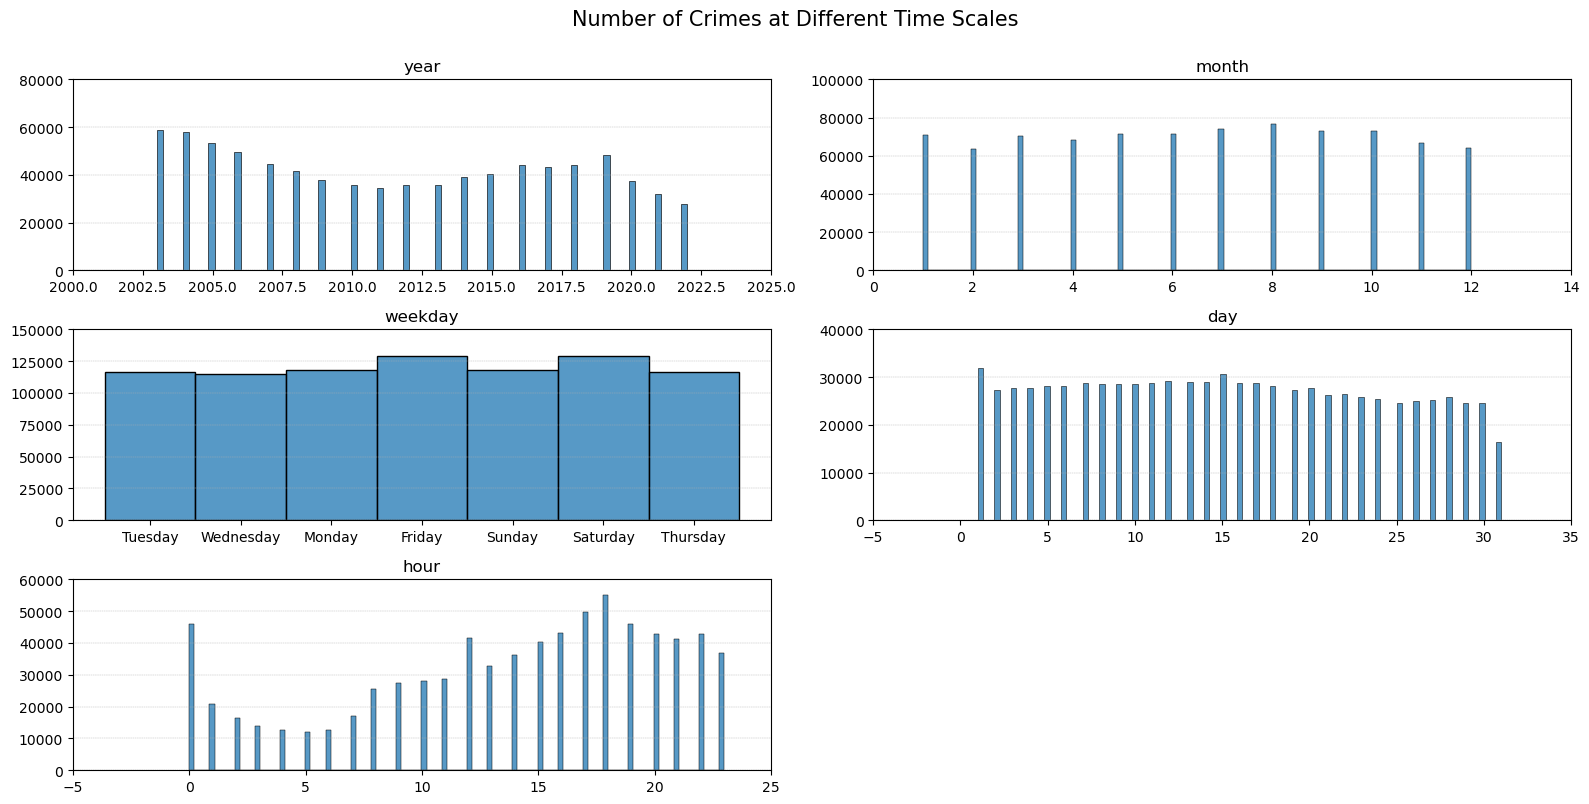

In [29]:
# Calculate and plot (count plot) the number of crimes at different time scales.

i=0
n_cols = 2
cols = ['year', 'month', 'weekday', 'day', 'hour']

fig, ax = plt.subplots(math.ceil((len(cols)/n_cols)), n_cols, figsize=(16,8))
fig.suptitle('Number of Crimes at Different Time Scales', fontsize=15, y=1.)

for col in cols:
    
    # remove Offences Against a Person crime type (as discussed above)
    if col=='hour':
        my_data = df_clean[~(df_clean['type']=='Offence Against a Person')].copy()
    else:
        my_data = df_clean.copy()
    
    g = sns.histplot(x=col, data=my_data, ax=ax[i//n_cols,i%n_cols])
    
    g.set_xticks(g.get_xticks(), fontsize = 12)
    g.set_yticks(g.get_yticks(), fontsize = 12)
    g.set_title(col, fontsize=12)
    g.set_xlabel('')
    g.set_ylabel('')
    ax[i//n_cols,i%n_cols].grid(axis = 'y', linestyle = '--', linewidth = 0.3)
    
    i=i+1

# remove the extra, empty last subplot (if applicable)
if len(cols)%2 == 1:
    ax[i//n_cols,i%n_cols].set_axis_off()
    
fig.tight_layout()

In [30]:
df_clean['weekday'].value_counts()

Friday       129379
Saturday     128677
Monday       118219
Sunday       117921
Tuesday      116603
Thursday     116548
Wednesday    115145
Name: weekday, dtype: int64

In [31]:
print('Total number of crimes per season:')
print(' spring:', df_clean[df_clean['month'].isin([3,4,5])].shape[0])
print(' summer:', df_clean[df_clean['month'].isin([6,7,8])].shape[0])
print(' fall:', df_clean[df_clean['month'].isin([9,10,11])].shape[0])
print(' winter:', df_clean[df_clean['month'].isin([1,2,12])].shape[0])

print('\nAverage number of crimes per season:')
print(' spring:', df_clean[df_clean['month'].isin([3,4,5])].groupby(['year'])['type'].count().mean())
print(' summer:', df_clean[df_clean['month'].isin([6,7,8])].groupby(['year'])['type'].count().mean())
print(' fall:', df_clean[df_clean['month'].isin([9,10,11])].groupby(['year'])['type'].count().mean())
print(' winter:', df_clean[df_clean['month'].isin([1,2,12])].groupby(['year'])['type'].count().mean())

Total number of crimes per season:
 spring: 209740
 summer: 222451
 fall: 212359
 winter: 197942

Average number of crimes per season:
 spring: 10487.0
 summer: 11122.55
 fall: 10617.95
 winter: 9897.1


- Crimes occur throughout the year.
- Summer has the highest amount of criminal activities, while winter has the lowest.
- Most of the crimes occur on Fridays and Saturdays, while the least amount of crimes occurs during the middle of the week.
- Most crimes occur from 12pm to 1am, with an exceptional peak at midnight. There is a significant drop of crimes from 12am to 1am. Crimes stay relatively low from 1am to 7am. Crimes are drastically reported around 8am and gradually increase throughout the day peaking at 6pm. In between, we have a smaller peak at noon.

The pattern in the `hour` suggests to follow the approach in [1] to divide the day into the following parts:
- Early morning: 1am - 7am
- Late morning: 8am - 1pm
- Afternoon: 2pm - 7pm
- Night: 8pm - 12am

In [32]:
# divide the day into parts
df_clean['part_of_day'] = 'early morning'
df_clean['part_of_day'] = np.where(df_clean['hour'].isin([8,9,10,11,12,13]), 'late morning', df_clean['part_of_day'])
df_clean['part_of_day'] = np.where(df_clean['hour'].isin([14,15,16,17,18,19]), 'afternoon', df_clean['part_of_day'])
df_clean['part_of_day'] = np.where(df_clean['hour'].isin([20,21,22,23,0]), 'night', df_clean['part_of_day'])

df_clean.head()

type  year  month  day  hour  minute     hundred_block  \
0  Theft from Vehicle  2017      2   21    22       0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017      3    8    12      45  1XX W GEORGIA ST   
2  Theft from Vehicle  2017      3   14    20       0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017      5    8     9      47  1XX W GEORGIA ST   
4  Theft from Vehicle  2017      5   17    13      18  1XX W GEORGIA ST   

               neighbourhood            x             y       date    weekday  \
0  Central Business District  491892.3455  5.458408e+06 2017-02-21    Tuesday   
1  Central Business District  491892.3455  5.458408e+06 2017-03-08  Wednesday   
2  Central Business District  491892.3455  5.458408e+06 2017-03-14    Tuesday   
3  Central Business District  491892.3455  5.458408e+06 2017-05-08     Monday   
4  Central Business District  491892.3455  5.458408e+06 2017-05-17  Wednesday   

    part_of_day  
0         night  
1  late morning  
2         night  
3  late morning  
4  late morning

## Create Spatial Blocks

As in [2], we build small spatial blocks and temporal blocks of our crima data.

- Our spatial blocks will be defined at the dissemination block level based on the "2021 Census – Boundary files".
- Our temporal locks will be defined as one day.

First, we convert the `x` and `y` coordinates from the UTM Zone 10 to latitudes and longitudes, and create a shapefile of the crime data.

Then, we assign the coordinates to small spatial locations, which have been defined via the "2021 Census – Boundary files". These boundary files are available every five years.
For simplicity, we use only the latest files from 2021.

In the end, we save the result as a GeoDataFrame.

In [33]:
# start with the original dataframe
df_clean = df.copy()

In [34]:
# transform column names to lower case
df_clean.columns = df_clean.columns.str.lower()

### Create Shapefile

We create a shapefile of the crime data.

In [20]:
# convert the x, y coordinates from UTM Zone 10 to latitude, longitude
myProj = Proj("+proj=utm +zone=10, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
lon, lat = myProj(df_clean['x'].values, df_clean['y'].values, inverse=True)

# add latitude, longitude to the dataframe
df_clean['latitude'] = lat
df_clean['longitude'] = lon

df_clean.head()

type  year  month  day  hour  minute     hundred_block  \
0  Theft from Vehicle  2017      2   21    22       0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017      3    8    12      45  1XX W GEORGIA ST   
2  Theft from Vehicle  2017      3   14    20       0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017      5    8     9      47  1XX W GEORGIA ST   
4  Theft from Vehicle  2017      5   17    13      18  1XX W GEORGIA ST   

               neighbourhood            x             y   latitude  longitude  
0  Central Business District  491892.3455  5.458408e+06  49.278376 -123.11147  
1  Central Business District  491892.3455  5.458408e+06  49.278376 -123.11147  
2  Central Business District  491892.3455  5.458408e+06  49.278376 -123.11147  
3  Central Business District  491892.3455  5.458408e+06  49.278376 -123.11147  
4  Central Business District  491892.3455  5.458408e+06  49.278376 -123.11147

In [21]:
# save the dataframe to a csv file
df_clean.to_csv('data/crime_data_coordinates.csv', index=False)

In [22]:
df_clean.dtypes

type              object
year               int64
month              int64
day                int64
hour               int64
minute             int64
hundred_block     object
neighbourhood     object
x                float64
y                float64
latitude         float64
longitude        float64
dtype: object

Using the code from [3], we create a shapefile of the crime data:

In [24]:
# create a shapefile of the crime data

# funtion to generate a .prj file
def getWKT_PRJ(epsg_code):
    import urllib.request
    with urllib.request.urlopen('http://spatialreference.org/ref/epsg/{0}/prettywkt/'.format(epsg_code)) as wkt:
        s = wkt.read().decode('utf-8')
        remove_spaces = s.replace(' ','')
        output = remove_spaces.replace('\n', '')
    return output

# create a point shapefile
crime_shp = shapefile.Writer('data/crime_shapefile', shapeType=shapefile.POINT)

# for every record there must be a corresponding geometry.
crime_shp.autoBalance = 1

# create the field names and data type for each.
crime_shp.field('TYPE', 'C')
crime_shp.field('YEAR', 'N')
crime_shp.field('MONTH', 'N')
crime_shp.field('DAY', 'N')
crime_shp.field('HOUR', 'N')
crime_shp.field('MINUTE', 'N')
crime_shp.field('HUNDRED_BLOCK', 'C')
crime_shp.field('NEIGHBOURHOOD', 'C')
crime_shp.field('X', 'N', decimal=30)
crime_shp.field('Y', 'N', decimal=30)

# count the features
counter = 1

# access the csv file
with open('data/crime_data_coordinates.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    # skip the header
    next(reader, None)
    
    #loop through each of the rows and assign the attributes to variables
    for row in reader:
        crime_type = row[0]
        crime_year = row[1]
        crime_month = row[2]
        crime_day = row[3]
        crime_hour = row[4]
        crime_minute = row[5]
        crime_hundred_block = row[6]
        crime_neighbourhood = row[7]
        crime_x = row[8]
        crime_y = row[9]
        latitude = row[10]
        longitude = row[11]

        # create the point geometry
        crime_shp.point(float(longitude),float(latitude))
        # add attribute data
        crime_shp.record(crime_type,crime_year,crime_month,crime_day,crime_hour,crime_minute,crime_hundred_block,
                         crime_neighbourhood,crime_x,crime_y)

        counter = counter + 1

# close the Shapefile
crime_shp.close()

# create a projection file
prj = open('data/crime_shapefile.prj', 'w')
epsg = getWKT_PRJ('4326')
prj.write(epsg)
prj.close()

### Spatial Join of the Crime Data Shapefile and the Boundary Files

We assign the crime data coordinates to small spatial blocks which have been defined in the "2021 Census – Boundary files".

In [10]:
# read the 2021 Census – Boundary files
poly_df = gpd.read_file(r'data/lda_000a21a_e/lda_000a21a_e.shp')

# Read the crime data shapefile that we just created.
# Since the boundary files are given in Lambert conformal conic projection [NAD83], 
# we need to transform the crime data coordinates to the NAD83 coordinate system.
point_df = gpd.read_file(r'data/crime_shapefile.shp').set_crs('epsg:4326').to_crs(3347)

# spatial join of the two GeoDataFrames
crime_df = gpd.sjoin(left_df=point_df, right_df=poly_df, how='left')
crime_df.head()

TYPE    YEAR  MONTH   DAY  HOUR  MINUTE        HUNDRED_BL  \
0  Theft from Vehicle  2017.0    2.0  21.0  22.0     0.0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017.0    3.0   8.0  12.0    45.0  1XX W GEORGIA ST   
2  Theft from Vehicle  2017.0    3.0  14.0  20.0     0.0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017.0    5.0   8.0   9.0    47.0  1XX W GEORGIA ST   
4  Theft from Vehicle  2017.0    5.0  17.0  13.0    18.0  1XX W GEORGIA ST   

                  NEIGHBOURH            X             Y  \
0  Central Business District  491892.3455  5.458408e+06   
1  Central Business District  491892.3455  5.458408e+06   
2  Central Business District  491892.3455  5.458408e+06   
3  Central Business District  491892.3455  5.458408e+06   
4  Central Business District  491892.3455  5.458408e+06   

                          geometry  index_right     DAUID              DGUID  \
0  POINT (4019199.308 2006597.176)      57442.0  59154184  2021S051259154184   
1  POINT (4019199.308 2006597.176)      57442.0  59154184  2021S051259154184   
2  POINT (4019199.308 2006597.176)      57442.0  59154184  2021S051259154184   
3  POINT (4019199.308 2006597.176)      57442.0  59154184  2021S051259154184   
4  POINT (4019199.308 2006597.176)      57442.0  59154184  2021S051259154184   

   LANDAREA PRUID  
0    0.0302    59  
1    0.0302    59  
2    0.0302    59  
3    0.0302    59  
4    0.0302    59

In [11]:
# drop unrelevant columns
crime_df.drop(columns=['index_right', 'DGUID', 'LANDAREA', 'PRUID'], inplace=True)
crime_df.head()

TYPE    YEAR  MONTH   DAY  HOUR  MINUTE        HUNDRED_BL  \
0  Theft from Vehicle  2017.0    2.0  21.0  22.0     0.0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017.0    3.0   8.0  12.0    45.0  1XX W GEORGIA ST   
2  Theft from Vehicle  2017.0    3.0  14.0  20.0     0.0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017.0    5.0   8.0   9.0    47.0  1XX W GEORGIA ST   
4  Theft from Vehicle  2017.0    5.0  17.0  13.0    18.0  1XX W GEORGIA ST   

                  NEIGHBOURH            X             Y  \
0  Central Business District  491892.3455  5.458408e+06   
1  Central Business District  491892.3455  5.458408e+06   
2  Central Business District  491892.3455  5.458408e+06   
3  Central Business District  491892.3455  5.458408e+06   
4  Central Business District  491892.3455  5.458408e+06   

                          geometry     DAUID  
0  POINT (4019199.308 2006597.176)  59154184  
1  POINT (4019199.308 2006597.176)  59154184  
2  POINT (4019199.308 2006597.176)  59154184  
3  POINT (4019199.308 2006597.176)  59154184  
4  POINT (4019199.308 2006597.176)  59154184

In [12]:
# transform column names to lower case
crime_df.columns = crime_df.columns.str.lower()
crime_df.head()

type    year  month   day  hour  minute        hundred_bl  \
0  Theft from Vehicle  2017.0    2.0  21.0  22.0     0.0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017.0    3.0   8.0  12.0    45.0  1XX W GEORGIA ST   
2  Theft from Vehicle  2017.0    3.0  14.0  20.0     0.0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017.0    5.0   8.0   9.0    47.0  1XX W GEORGIA ST   
4  Theft from Vehicle  2017.0    5.0  17.0  13.0    18.0  1XX W GEORGIA ST   

                  neighbourh            x             y  \
0  Central Business District  491892.3455  5.458408e+06   
1  Central Business District  491892.3455  5.458408e+06   
2  Central Business District  491892.3455  5.458408e+06   
3  Central Business District  491892.3455  5.458408e+06   
4  Central Business District  491892.3455  5.458408e+06   

                          geometry     dauid  
0  POINT (4019199.308 2006597.176)  59154184  
1  POINT (4019199.308 2006597.176)  59154184  
2  POINT (4019199.308 2006597.176)  59154184  
3  POINT (4019199.308 2006597.176)  59154184  
4  POINT (4019199.308 2006597.176)  59154184

In [13]:
# rename column names appropriately
crime_df.rename(columns = {'hundred_bl':'hundred_block', 'neighbourh': 'neighbourhood'}, inplace = True)
crime_df.head()

type    year  month   day  hour  minute     hundred_block  \
0  Theft from Vehicle  2017.0    2.0  21.0  22.0     0.0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017.0    3.0   8.0  12.0    45.0  1XX W GEORGIA ST   
2  Theft from Vehicle  2017.0    3.0  14.0  20.0     0.0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017.0    5.0   8.0   9.0    47.0  1XX W GEORGIA ST   
4  Theft from Vehicle  2017.0    5.0  17.0  13.0    18.0  1XX W GEORGIA ST   

               neighbourhood            x             y  \
0  Central Business District  491892.3455  5.458408e+06   
1  Central Business District  491892.3455  5.458408e+06   
2  Central Business District  491892.3455  5.458408e+06   
3  Central Business District  491892.3455  5.458408e+06   
4  Central Business District  491892.3455  5.458408e+06   

                          geometry     dauid  
0  POINT (4019199.308 2006597.176)  59154184  
1  POINT (4019199.308 2006597.176)  59154184  
2  POINT (4019199.308 2006597.176)  59154184  
3  POINT (4019199.308 2006597.176)  59154184  
4  POINT (4019199.308 2006597.176)  59154184

In [51]:
# replace inf-points with 0-points (otherwise we can't save the dataframe)
mask = np.isinf(crime_df['geometry'].x)
crime_df.loc[mask, 'geometry'] = gpd.points_from_xy([0] * np.isinf(crime_df['geometry'].x).values.sum(), [0] * np.isinf(crime_df['geometry'].x).values.sum())

In [53]:
# save the crime GeoDataFrame
crime_df.to_file('data/crime_df.shp')

In [54]:
# confirm the Coordinate Reference System (crs) of our crime data
crime_df.crs

<Projected CRS: EPSG:3347>
Name: NAD83 / Statistics Canada Lambert
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada
- bounds: (-141.01, 40.04, -47.74, 86.46)
Coordinate Operation:
- name: Statistics Canada Lambert
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## EDA of the Crime GeoDataFrame

In [35]:
# read the crime GeoDataFrame
crime_df = gpd.read_file(r'data/crime_df.shp')
crime_df.head()

type    year  month   day  hour  minute        hundred_bl  \
0  Theft from Vehicle  2017.0    2.0  21.0  22.0     0.0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017.0    3.0   8.0  12.0    45.0  1XX W GEORGIA ST   
2  Theft from Vehicle  2017.0    3.0  14.0  20.0     0.0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017.0    5.0   8.0   9.0    47.0  1XX W GEORGIA ST   
4  Theft from Vehicle  2017.0    5.0  17.0  13.0    18.0  1XX W GEORGIA ST   

                  neighbourh            x             y     dauid  \
0  Central Business District  491892.3455  5.458408e+06  59154184   
1  Central Business District  491892.3455  5.458408e+06  59154184   
2  Central Business District  491892.3455  5.458408e+06  59154184   
3  Central Business District  491892.3455  5.458408e+06  59154184   
4  Central Business District  491892.3455  5.458408e+06  59154184   

                          geometry  
0  POINT (4019199.308 2006597.176)  
1  POINT (4019199.308 2006597.176)  
2  POINT (4019199.308 2006597.176)  
3  POINT (4019199.308 2006597.176)  
4  POINT (4019199.308 2006597.176)

In [36]:
# rename column names appropriately
crime_df.rename(columns = {'hundred_bl':'hundred_block', 'neighbourh': 'neighbourhood'}, inplace = True)

In [37]:
# confirm the Coordinate Reference System (crs) of our crime data
crime_df.crs

<Projected CRS: EPSG:3347>
Name: NAD83 / Statistics Canada Lambert
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada
- bounds: (-141.01, 40.04, -47.74, 86.46)
Coordinate Operation:
- name: Statistics Canada Lambert
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [38]:
# data size
crime_df.shape

(842492, 12)

In [39]:
# data type of each column
crime_df.dtypes

type               object
year              float64
month             float64
day               float64
hour              float64
minute            float64
hundred_block      object
neighbourhood      object
x                 float64
y                 float64
dauid              object
geometry         geometry
dtype: object

In [40]:
# transform specific columns to integers
for col in ['year', 'month', 'day', 'hour', 'minute']:
    crime_df[col] = crime_df[col].astype('int64')

crime_df.dtypes

type               object
year                int64
month               int64
day                 int64
hour                int64
minute              int64
hundred_block      object
neighbourhood      object
x                 float64
y                 float64
dauid              object
geometry         geometry
dtype: object

In [42]:
# number of spatial blocks
crime_df['dauid'].nunique()

1035

We have 1035 spatial blocks.

<AxesSubplot:>

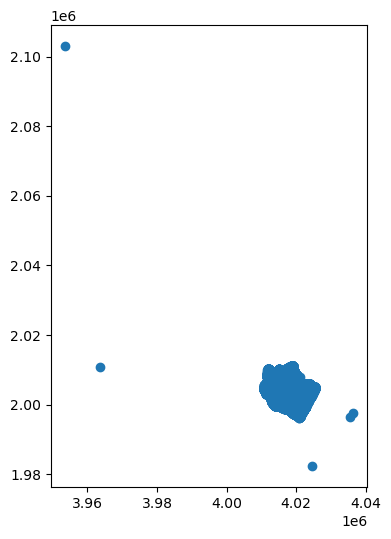

In [65]:
# plot the coordinates
crime_df[~(crime_df['dauid'].isna())].plot();

There are a few wrong coordinates. Let's look at them:

In [66]:
crime_df[(~(crime_df['dauid'].isna())) & 
         ((crime_df['geometry'].x<4e6) | (crime_df['geometry'].x>4.03e6) | (crime_df['geometry'].y<1.99e6))]

type  year  month  day  \
253597  Vehicle Collision or Pedestrian Struck (with I...  2015      8   30   
260056  Vehicle Collision or Pedestrian Struck (with I...  2006      2   24   
261052  Vehicle Collision or Pedestrian Struck (with I...  2005      5   17   
268275  Vehicle Collision or Pedestrian Struck (with I...  2015      4   29   
274275  Vehicle Collision or Pedestrian Struck (with I...  2014      7   13   

        hour  minute                hundred_block neighbourhood         x  \
253597    20       0      16XX BLOCK VICTORIA AVE          None  441008.0   
260056    23      52                 9XX PRIOR ST          None  511176.0   
261052    10      10                 BRIDGEWAY ST          None  511303.0   
268275    17      14      GRANVILLE ST / 58TH AVE          None  507998.0   
274275    20      30  S / L 300 BLK E HASTINGS ST          None  388373.0   

                y     dauid                         geometry  
253597  5435925.0  59210459  POINT (3963740.148 2010740.639)  
260056  5457153.0  59151593  POINT (4035618.407 1996430.370)  
261052  5458441.0  59154076  POINT (4036335.178 1997507.002)  
268275  5439487.0  59152290  POINT (4024515.993 1982333.737)  
274275  5512579.0  59270086  POINT (3953605.387 2103052.824)

These are five clear wrong coordinates, which don't have a neighbourhood either. We decide to remove them:

In [43]:
# remove the five wrong coordinates
crime_df = crime_df[~((~(crime_df['dauid'].isna())) & 
                      ((crime_df['geometry'].x<4e6) | (crime_df['geometry'].x>4.03e6) | (crime_df['geometry'].y<1.99e6)))]

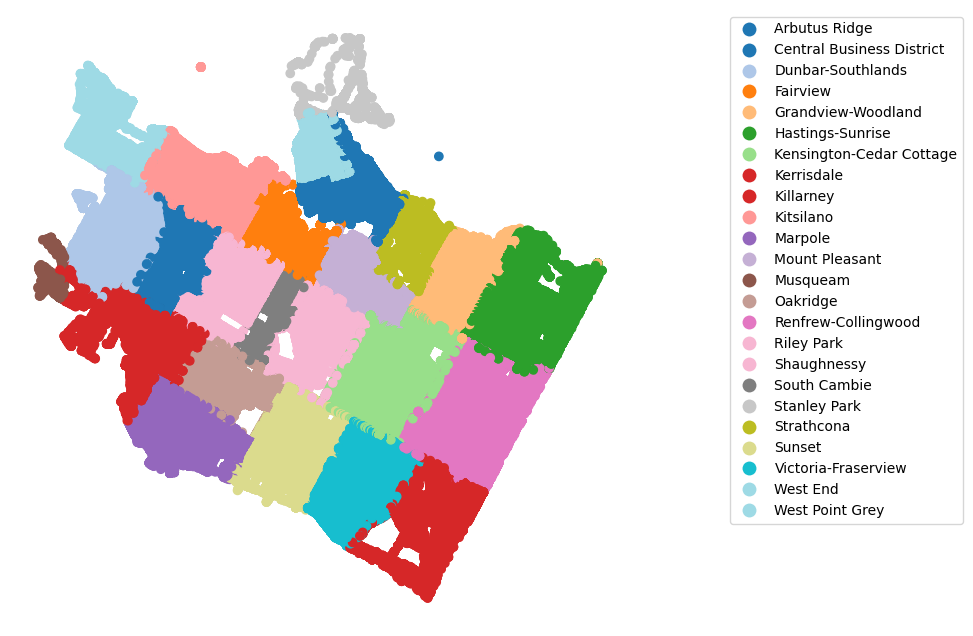

In [69]:
# plot the coordinates color-coded by neighbourhood
fig, ax = plt.subplots(figsize=(12, 8))

crime_df[~(crime_df['dauid'].isna())].plot(column='neighbourhood', ax=ax, legend=True, cmap='tab20')

# adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))

ax.set_axis_off()
plt.show()

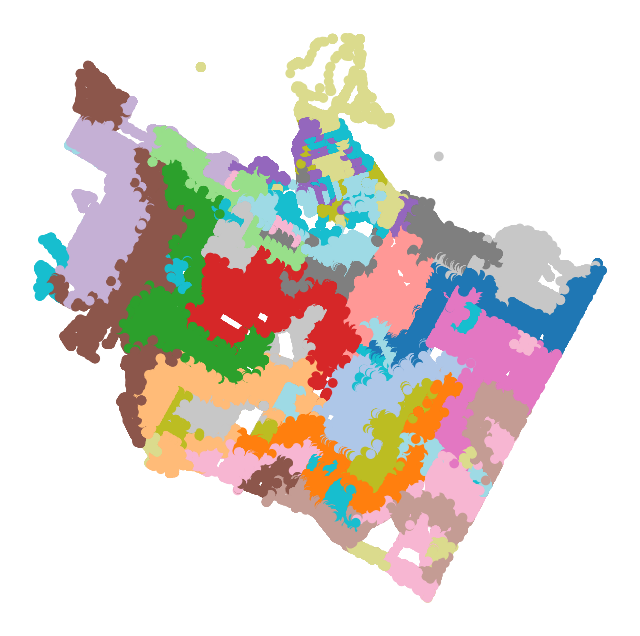

In [70]:
# plot the coordinates color-coded by dauid
fig, ax = plt.subplots(figsize=(12, 8))

crime_df[~(crime_df['dauid'].isna())].plot(column='dauid', ax=ax, cmap='tab20')

ax.set_axis_off()
plt.show()

Two points are mapped on the water. Let's look at them:

<AxesSubplot:>

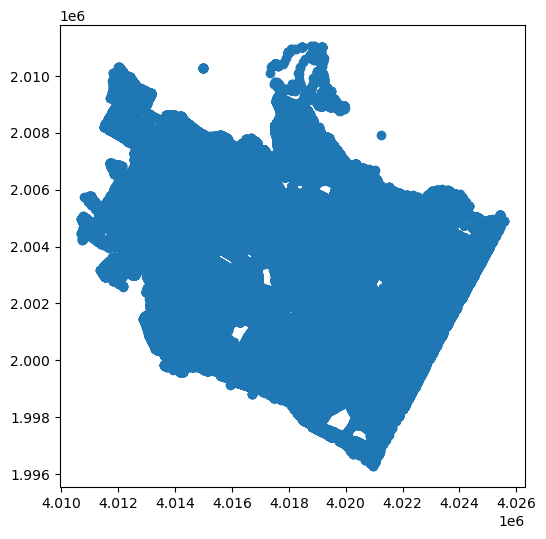

In [71]:
# plot the coordinates with axes to find out the location of the water-points
crime_df[~(crime_df['dauid'].isna())].plot();

In [44]:
# dataframe of all water-points
crime_df[(~(crime_df['dauid'].isna())) & 
         (((crime_df['geometry'].x.between(4.014e6,4.016e6)) & (crime_df['geometry'].y>2.0095e6)) |
          ((crime_df['geometry'].y.between(2.0075e6,2.0085e6)) & (crime_df['geometry'].x>4.0208e6)))]

type  year  month  day  hour  minute  \
188146                   Theft of Bicycle  2004      5   25    11      30   
397362  Break and Enter Residential/Other  2009      7   28    12      30   
397363  Break and Enter Residential/Other  2015     12   24    18       0   
498015                           Mischief  2009      1   28    15       9   
774791                        Other Theft  2019      5   28    15      21   
774792                        Other Theft  2019      5   29    17       9   
774793                        Other Theft  2017      5   22    15      33   
774794                        Other Theft  2017      7   11    17       0   
774795                        Other Theft  2018      6    5    19       0   
774796                        Other Theft  2018      6    6     8       0   
774797                        Other Theft  2018      6    7    19      30   
774798                        Other Theft  2006      8    5    21      45   
774799                        Other Theft  2009      2   20    15       7   
774800                        Other Theft  2009      6   20    23      30   
774801                        Other Theft  2010      5   25    15      55   
774802                        Other Theft  2012      7   28    15       0   
774803                        Other Theft  2015     12    6    12      28   

                 hundred_block              neighbourhood            x  \
188146  2XX BURRARD INLET WWAY  Central Business District  493077.7496   
397362           X ENGLISH BAY                  Kitsilano  486422.5555   
397363           X ENGLISH BAY                  Kitsilano  486422.5555   
498015           X ENGLISH BAY                  Kitsilano  486422.5351   
774791           X ENGLISH BAY                  Kitsilano  486422.5351   
774792           X ENGLISH BAY                  Kitsilano  486422.5351   
774793           X ENGLISH BAY                  Kitsilano  486422.5352   
774794           X ENGLISH BAY                  Kitsilano  486422.5352   
774795           X ENGLISH BAY                  Kitsilano  486422.5352   
774796           X ENGLISH BAY                  Kitsilano  486422.5352   
774797           X ENGLISH BAY                  Kitsilano  486422.5352   
774798           X ENGLISH BAY                  Kitsilano  486422.5555   
774799           X ENGLISH BAY                  Kitsilano  486422.5555   
774800           X ENGLISH BAY                  Kitsilano  486422.5555   
774801           X ENGLISH BAY                  Kitsilano  486422.5555   
774802           X ENGLISH BAY                  Kitsilano  486422.5555   
774803           X ENGLISH BAY                  Kitsilano  486422.5555   

                   y     dauid                         geometry  
188146  5.460549e+06  59153241  POINT (4021250.711 2007927.396)  
397362  5.459672e+06  59153569  POINT (4014970.452 2010283.633)  
397363  5.459672e+06  59153569  POINT (4014970.452 2010283.633)  
498015  5.459672e+06  59153569  POINT (4014970.435 2010283.645)  
774791  5.459672e+06  59153569  POINT (4014970.435 2010283.645)  
774792  5.459672e+06  59153569  POINT (4014970.435 2010283.645)  
774793  5.459672e+06  59153569  POINT (4014970.435 2010283.645)  
774794  5.459672e+06  59153569  POINT (4014970.435 2010283.645)  
774795  5.459672e+06  59153569  POINT (4014970.435 2010283.645)  
774796  5.459672e+06  59153569  POINT (4014970.435 2010283.645)  
774797  5.459672e+06  59153569  POINT (4014970.435 2010283.645)  
774798  5.459672e+06  59153569  POINT (4014970.452 2010283.633)  
774799  5.459672e+06  59153569  POINT (4014970.452 2010283.633)  
774800  5.459672e+06  59153569  POINT (4014970.452 2010283.633)  
774801  5.459672e+06  59153569  POINT (4014970.452 2010283.633)  
774802  5.459672e+06  59153569  POINT (4014970.452 2010283.633)  
774803  5.459672e+06  59153569  POINT (4014970.452 2010283.633)

In [83]:
# check the dauid of the first water-point to the right
crime_df[crime_df['dauid']=='59153241'].shape[0]

1

In [84]:
# check the dauid of the second water-point to the left
crime_df[crime_df['dauid']=='59153569'].shape[0]

16

The water-point to the right has been assigned to `dauid=59153241`, which consistst of 1 point. The water-point to the leftt has been assigned to `dauid=59153569`, which consistst of 16 points.

Since these are the only points in the two `dauid` regions, we decide to remove the water-points:

In [45]:
# remove the water-points
crime_df = crime_df[~((~(crime_df['dauid'].isna())) & 
                      (((crime_df['geometry'].x.between(4.014e6,4.016e6)) & (crime_df['geometry'].y>2.0095e6)) |
                       ((crime_df['geometry'].y.between(2.0075e6,2.0085e6)) & (crime_df['geometry'].x>4.0208e6))))]

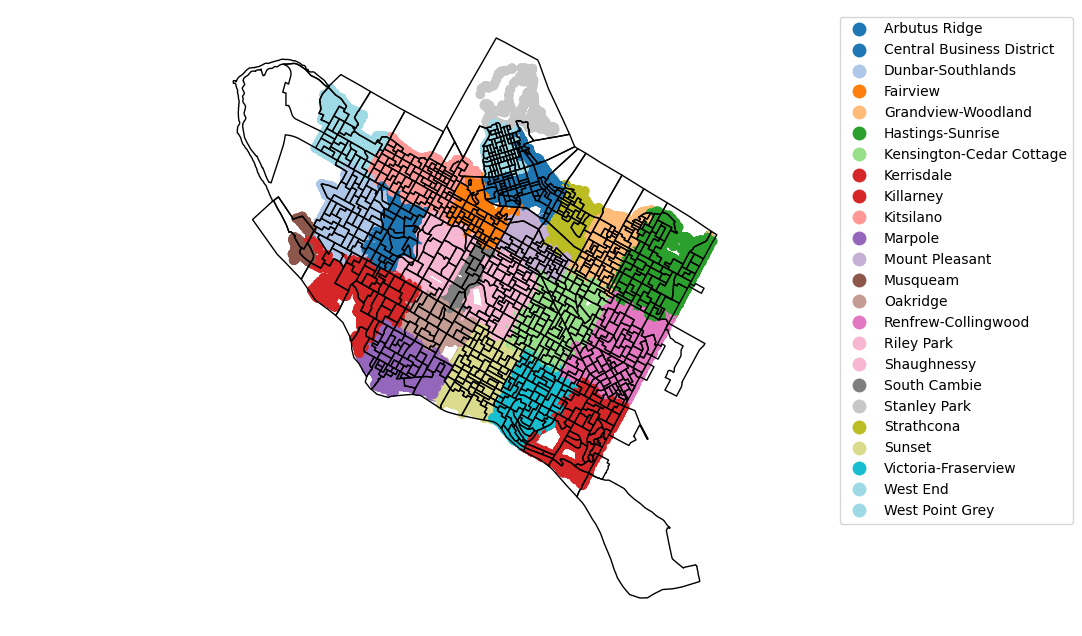

In [91]:
# plot the coordinates color-coded by neighbourhood together with the boundaries from the 2021 Census – Boundary files

fig, ax = plt.subplots(figsize=(12, 8))

# read and plot the 2021 Census – Boundary files
poly_df = gpd.read_file(r'data/lda_000a21a_e/lda_000a21a_e.shp')
poly_df[(poly_df['DAUID'].str.startswith('5915')) & (poly_df['DAUID'].isin(list(crime_df['dauid'].unique())))].plot(alpha=1,
                    facecolor="none",
                    edgecolor="black",
                    zorder=10,
                    ax=ax)

# plot the crime data
crime_df[~(crime_df['dauid'].isna())].plot(column='neighbourhood',
                  ax=ax,
                  legend=True, cmap='tab20')

# adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))

ax.set_axis_off()
plt.axis('equal')
plt.show()

In [46]:
# create datetime
crime_df['date'] = pd.to_datetime(crime_df[['year','month','day']])

In [47]:
# get weekday
crime_df['weekday'] = crime_df['date'].dt.day_name()
crime_df.sort_values(by=['date']).head()

type  year  month  day  hour  minute  \
215939    Theft of Vehicle  2003      1    1    23       0   
772208         Other Theft  2003      1    1    12       0   
101830  Theft from Vehicle  2003      1    1    22       0   
662296         Other Theft  2003      1    1    16       0   
462929            Mischief  2003      1    1    16      45   

                   hundred_block              neighbourhood            x  \
215939           17XX E 36TH AVE   Kensington-Cedar Cottage  494815.8449   
772208  LARCH ST / POINT GREY RD                  Kitsilano  488211.2201   
101830              6XX UNION ST                 Strathcona  493382.6468   
662296            33XX SOPHIA ST                 Riley Park  492829.5753   
462929           5X E CORDOVA ST  Central Business District  492492.1655   

                   y     dauid                         geometry       date  \
215939  5.453868e+06  59150403  POINT (4019643.200 2001218.224) 2003-01-01   
772208  5.457879e+06  59150884  POINT (4015704.387 2007861.251) 2003-01-01   
101830  5.458305e+06  59150752  POINT (4020464.845 2005805.234) 2003-01-01   
662296  5.455872e+06  59150704  POINT (4018833.558 2003919.820) 2003-01-01   
462929  5.458854e+06  59153580  POINT (4019937.613 2006707.953) 2003-01-01   

          weekday  
215939  Wednesday  
772208  Wednesday  
101830  Wednesday  
662296  Wednesday  
462929  Wednesday

In [48]:
# get part of the day (as we did further above)
crime_df['part_of_day'] = 'early morning'
crime_df['part_of_day'] = np.where(crime_df['hour'].isin([8,9,10,11,12,13]), 'late morning', crime_df['part_of_day'])
crime_df['part_of_day'] = np.where(crime_df['hour'].isin([14,15,16,17,18,19]), 'afternoon', crime_df['part_of_day'])
crime_df['part_of_day'] = np.where(crime_df['hour'].isin([20,21,22,23,0]), 'night', crime_df['part_of_day'])

crime_df.head()

type  year  month  day  hour  minute     hundred_block  \
0  Theft from Vehicle  2017      2   21    22       0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017      3    8    12      45  1XX W GEORGIA ST   
2  Theft from Vehicle  2017      3   14    20       0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017      5    8     9      47  1XX W GEORGIA ST   
4  Theft from Vehicle  2017      5   17    13      18  1XX W GEORGIA ST   

               neighbourhood            x             y     dauid  \
0  Central Business District  491892.3455  5.458408e+06  59154184   
1  Central Business District  491892.3455  5.458408e+06  59154184   
2  Central Business District  491892.3455  5.458408e+06  59154184   
3  Central Business District  491892.3455  5.458408e+06  59154184   
4  Central Business District  491892.3455  5.458408e+06  59154184   

                          geometry       date    weekday   part_of_day  
0  POINT (4019199.308 2006597.176) 2017-02-21    Tuesday         night  
1  POINT (4019199.308 2006597.176) 2017-03-08  Wednesday  late morning  
2  POINT (4019199.308 2006597.176) 2017-03-14    Tuesday         night  
3  POINT (4019199.308 2006597.176) 2017-05-08     Monday  late morning  
4  POINT (4019199.308 2006597.176) 2017-05-17  Wednesday  late morning

## Classification

### Data Preprocessing

In [253]:
# read the crime GeoDataFrame
crime_df = gpd.read_file(r'data/crime_df.shp')
crime_df.head()

type    year  month   day  hour  minute        hundred_bl  \
0  Theft from Vehicle  2017.0    2.0  21.0  22.0     0.0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017.0    3.0   8.0  12.0    45.0  1XX W GEORGIA ST   
2  Theft from Vehicle  2017.0    3.0  14.0  20.0     0.0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017.0    5.0   8.0   9.0    47.0  1XX W GEORGIA ST   
4  Theft from Vehicle  2017.0    5.0  17.0  13.0    18.0  1XX W GEORGIA ST   

                  neighbourh            x             y     dauid  \
0  Central Business District  491892.3455  5.458408e+06  59154184   
1  Central Business District  491892.3455  5.458408e+06  59154184   
2  Central Business District  491892.3455  5.458408e+06  59154184   
3  Central Business District  491892.3455  5.458408e+06  59154184   
4  Central Business District  491892.3455  5.458408e+06  59154184   

                          geometry  
0  POINT (4019199.308 2006597.176)  
1  POINT (4019199.308 2006597.176)  
2  POINT (4019199.308 2006597.176)  
3  POINT (4019199.308 2006597.176)  
4  POINT (4019199.308 2006597.176)

In [254]:
# rename columns accordingly
crime_df.rename(columns = {'hundred_bl':'hundred_block', 'neighbourh': 'neighbourhood'}, inplace = True)

In [255]:
# convert columns that should be integers to int64
for col in ['year', 'month', 'day', 'hour', 'minute']:
    crime_df[col] = crime_df[col].astype('int64')

crime_df.dtypes

type               object
year                int64
month               int64
day                 int64
hour                int64
minute              int64
hundred_block      object
neighbourhood      object
x                 float64
y                 float64
dauid              object
geometry         geometry
dtype: object

In [256]:
# remove the five wrong coordinates (we discovered them in the previous section)
crime_df = crime_df[~((~(crime_df['dauid'].isna())) & 
                      ((crime_df['geometry'].x<4e6) | (crime_df['geometry'].x>4.03e6) | (crime_df['geometry'].y<1.99e6)))]

In [257]:
# remove the water-points (we discovered them in the previous section)
crime_df = crime_df[~((~(crime_df['dauid'].isna())) & 
                      (((crime_df['geometry'].x.between(4.014e6,4.016e6)) & (crime_df['geometry'].y>2.0095e6)) |
                       ((crime_df['geometry'].y.between(2.0075e6,2.0085e6)) & (crime_df['geometry'].x>4.0208e6))))]

In [258]:
# create datetime
crime_df['date'] = pd.to_datetime(crime_df[['year','month','day']])

In [259]:
# get weekday
crime_df['weekday'] = crime_df['date'].dt.day_name()
crime_df.sort_values(by=['date']).head()

type  year  month  day  hour  minute  \
215939    Theft of Vehicle  2003      1    1    23       0   
772208         Other Theft  2003      1    1    12       0   
101830  Theft from Vehicle  2003      1    1    22       0   
662296         Other Theft  2003      1    1    16       0   
462929            Mischief  2003      1    1    16      45   

                   hundred_block              neighbourhood            x  \
215939           17XX E 36TH AVE   Kensington-Cedar Cottage  494815.8449   
772208  LARCH ST / POINT GREY RD                  Kitsilano  488211.2201   
101830              6XX UNION ST                 Strathcona  493382.6468   
662296            33XX SOPHIA ST                 Riley Park  492829.5753   
462929           5X E CORDOVA ST  Central Business District  492492.1655   

                   y     dauid                         geometry       date  \
215939  5.453868e+06  59150403  POINT (4019643.200 2001218.224) 2003-01-01   
772208  5.457879e+06  59150884  POINT (4015704.387 2007861.251) 2003-01-01   
101830  5.458305e+06  59150752  POINT (4020464.845 2005805.234) 2003-01-01   
662296  5.455872e+06  59150704  POINT (4018833.558 2003919.820) 2003-01-01   
462929  5.458854e+06  59153580  POINT (4019937.613 2006707.953) 2003-01-01   

          weekday  
215939  Wednesday  
772208  Wednesday  
101830  Wednesday  
662296  Wednesday  
462929  Wednesday

In [260]:
# get part of the day (as we did further above)
crime_df['part_of_day'] = 'early morning'
crime_df['part_of_day'] = np.where(crime_df['hour'].isin([8,9,10,11,12,13]), 'late morning', crime_df['part_of_day'])
crime_df['part_of_day'] = np.where(crime_df['hour'].isin([14,15,16,17,18,19]), 'afternoon', crime_df['part_of_day'])
crime_df['part_of_day'] = np.where(crime_df['hour'].isin([20,21,22,23,0]), 'night', crime_df['part_of_day'])

crime_df.head()

type  year  month  day  hour  minute     hundred_block  \
0  Theft from Vehicle  2017      2   21    22       0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017      3    8    12      45  1XX W GEORGIA ST   
2  Theft from Vehicle  2017      3   14    20       0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017      5    8     9      47  1XX W GEORGIA ST   
4  Theft from Vehicle  2017      5   17    13      18  1XX W GEORGIA ST   

               neighbourhood            x             y     dauid  \
0  Central Business District  491892.3455  5.458408e+06  59154184   
1  Central Business District  491892.3455  5.458408e+06  59154184   
2  Central Business District  491892.3455  5.458408e+06  59154184   
3  Central Business District  491892.3455  5.458408e+06  59154184   
4  Central Business District  491892.3455  5.458408e+06  59154184   

                          geometry       date    weekday   part_of_day  
0  POINT (4019199.308 2006597.176) 2017-02-21    Tuesday         night  
1  POINT (4019199.308 2006597.176) 2017-03-08  Wednesday  late morning  
2  POINT (4019199.308 2006597.176) 2017-03-14    Tuesday         night  
3  POINT (4019199.308 2006597.176) 2017-05-08     Monday  late morning  
4  POINT (4019199.308 2006597.176) 2017-05-17  Wednesday  late morning

Clean data based on the findings from the EDA:

In [261]:
crime_df = crime_df[~(crime_df['type']=='Offence Against a Person')]

In [262]:
crime_df = crime_df[~(crime_df['hundred_block']=='OFFSET TO PROTECT PRIVACY')]

In [263]:
crime_df = crime_df[~(crime_df['hundred_block'].str.contains('NK_LOC', na=False))]

In [264]:
crime_df.dropna(subset=['dauid'], inplace=True)

In [265]:
crime_df.head()

type  year  month  day  hour  minute     hundred_block  \
0  Theft from Vehicle  2017      2   21    22       0  1XX W GEORGIA ST   
1  Theft from Vehicle  2017      3    8    12      45  1XX W GEORGIA ST   
2  Theft from Vehicle  2017      3   14    20       0  1XX W GEORGIA ST   
3  Theft from Vehicle  2017      5    8     9      47  1XX W GEORGIA ST   
4  Theft from Vehicle  2017      5   17    13      18  1XX W GEORGIA ST   

               neighbourhood            x             y     dauid  \
0  Central Business District  491892.3455  5.458408e+06  59154184   
1  Central Business District  491892.3455  5.458408e+06  59154184   
2  Central Business District  491892.3455  5.458408e+06  59154184   
3  Central Business District  491892.3455  5.458408e+06  59154184   
4  Central Business District  491892.3455  5.458408e+06  59154184   

                          geometry       date    weekday   part_of_day  
0  POINT (4019199.308 2006597.176) 2017-02-21    Tuesday         night  
1  POINT (4019199.308 2006597.176) 2017-03-08  Wednesday  late morning  
2  POINT (4019199.308 2006597.176) 2017-03-14    Tuesday         night  
3  POINT (4019199.308 2006597.176) 2017-05-08     Monday  late morning  
4  POINT (4019199.308 2006597.176) 2017-05-17  Wednesday  late morning

In [268]:
# convert the dauid to integer
crime_df['dauid'] = crime_df['dauid'].astype('int64')
crime_df.dtypes

type                     object
year                      int64
month                     int64
day                       int64
hour                      int64
minute                    int64
hundred_block            object
neighbourhood            object
x                       float64
y                       float64
dauid                     int64
geometry               geometry
date             datetime64[ns]
weekday                  object
part_of_day              object
dtype: object

In [269]:
# latest date
crime_df['date'].max()

Timestamp('2022-10-21 00:00:00')

In [270]:
# delete the last day of our dataframe since it's likely incomplete
crime_df = crime_df[~((crime_df['year']==2022) & (crime_df['month']==10) & (crime_df['day']==21))]

In [271]:
# earliest date
crime_df['date'].min()

Timestamp('2003-01-01 00:00:00')

In [272]:
# restrict data to after 2018 due to storage limitations
crime_df = crime_df[crime_df['year']>=2019]

In [276]:
# number of days between our earliest and latest date
(crime_df['date'].max()-crime_df['date'].min()).days

1388

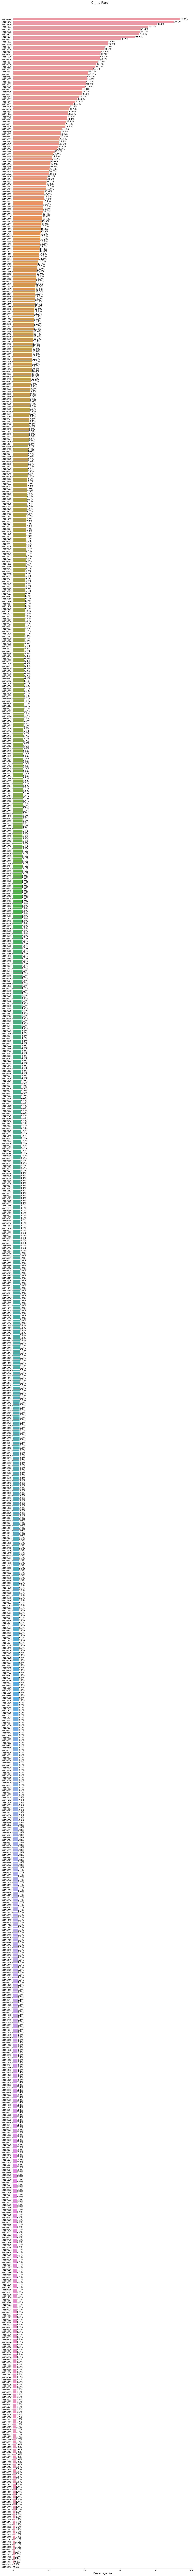

In [277]:
# Calculate and plot (bar plot) the crime rate per spatial block.

i=0
n_cols = 2

fig, ax = plt.subplots(figsize=(16,230))
fig.suptitle('Crime Rate', fontsize=15, y=0.885)

crime_rate = crime_df.groupby('dauid')['date'].nunique()*100./(crime_df['date'].max()-crime_df['date'].min()).days
crime_rate_df = pd.DataFrame(data=crime_rate.values, columns=['Percentage (%)'], index=crime_rate.index)
crime_rate_df.reset_index(inplace=True)
crime_rate_df.sort_values(by='Percentage (%)',ascending=False,inplace=True)

g = sns.barplot(y=crime_rate_df['dauid'].astype(str), x='Percentage (%)', data=crime_rate_df, ax=ax)
    
g.set_xticks(g.get_xticks(), fontsize = 12)
g.set_yticks(g.get_yticks(), fontsize = 12)
g.set_ylabel('')
g.set_xlabel('Percentage (%)', fontsize = 12)
    
# add percentages as text to the bars
for container in g.containers:
    g.bar_label(container, fmt='%.1f%%', fontsize=12)
left, right = g.get_xlim()
g.set_xlim(left, right+0.2);

In [279]:
# remove spatial blocks with a crime rate of less than 2.5% of days
crime_df = crime_df[~crime_df['dauid'].isin(list(crime_rate_df[crime_rate_df['Percentage (%)']<2.5]['dauid']))]
crime_df['dauid'].nunique()

807

Check for spatial blocks that are assigned to multiple neighbourhoods. We unify it by taking the neighbourhood with the highest counts per spatial block.

In [281]:
# indices of spatial blocks that are assigned to multiple neighbourhoods
mask = crime_df.groupby('dauid')['neighbourhood'].nunique()>1

In [282]:
# list of dauids that are assigned to multiple neighbourhoods
multiple_neighbours_ids = list(crime_df.groupby('dauid')['neighbourhood'].nunique()[mask].index)

In [283]:
# for each dauid, take the neighbourhood with the highest counts
for id in multiple_neighbours_ids:
    neighbourhood_counts = crime_df[crime_df['dauid']==id]['neighbourhood'].value_counts()
    max_count = neighbourhood_counts.max()
    dauid_neighbourhood = neighbourhood_counts[neighbourhood_counts==max_count].index[0]
    crime_df['neighbourhood'] = np.where(crime_df['dauid']==id, dauid_neighbourhood, crime_df['neighbourhood'])

Expand our dataframe: for each spatial block, create a day between our earliest and latest date. And for each day, create the four parts of a day (early morning, late morning, afternoon, evening). For each entry, create a boolean `crime` that states whether a crime happend on a part of the day (=1) or not (=0):

In [284]:
# create object for the expanded dataframe
crime_df_full = pd.DataFrame(columns=['dauid', 'neighbourhood', 'date', 'year', 'month', 'day', 'weekday', 'season', 
                                      'part_of_day', 'crime'])

# loop over all spatial blocks
for my_id in crime_df['dauid'].unique():
    
    # create object for the expanded dataframe of a spatial block
    crime_df_dauid = pd.DataFrame(data=0, columns=['dauid', 'neighbourhood', 'date', 'year', 'month', 'day', 'weekday', 'season', 
                                                   'part_of_day', 'crime'],
                                  index=list(range(0,(crime_df['date'].max()-crime_df['date'].min()).days)))
    
    # fill expanded dataframe
    crime_df_dauid['date'] = pd.Series(pd.date_range(start='1/1/2019', end='10/20/2022'))
    crime_df_dauid['dauid'] = my_id
    crime_df_dauid['neighbourhood'] = crime_df[crime_df['dauid']==my_id]['neighbourhood'].iloc[0]
    crime_df_dauid['weekday'] = crime_df_dauid['date'].dt.day_name()
    crime_df_dauid['year'] = crime_df_dauid['date'].dt.year
    crime_df_dauid['month'] = crime_df_dauid['date'].dt.month
    crime_df_dauid['day'] = crime_df_dauid['date'].dt.day
    
    # add season
    crime_df_dauid['season'] = 'spring'
    crime_df_dauid['season'] = np.where(crime_df_dauid['month'].isin([6,7,8]), 'summer', crime_df_dauid['season'])
    crime_df_dauid['season'] = np.where(crime_df_dauid['month'].isin([9,10,11]), 'fall', crime_df_dauid['season'])
    crime_df_dauid['season'] = np.where(crime_df_dauid['month'].isin([1,2,12]), 'winter', crime_df_dauid['season'])

    # add part of day
    crime_df_dauid['part_of_day'] = 'early morning'  
    crime_df_dauid_2 = crime_df_dauid.copy()
    crime_df_dauid_3 = crime_df_dauid.copy()
    crime_df_dauid_4 = crime_df_dauid.copy()
    crime_df_dauid_2['part_of_day'] = 'late morning'
    crime_df_dauid_3['part_of_day'] = 'afternoon'
    crime_df_dauid_4['part_of_day'] = 'night'
    crime_df_dauid = crime_df_dauid.append(crime_df_dauid_2, ignore_index=True)
    crime_df_dauid = crime_df_dauid.append(crime_df_dauid_3, ignore_index=True)
    crime_df_dauid = crime_df_dauid.append(crime_df_dauid_4, ignore_index=True)
    
    # add crime
    for index, row in crime_df[crime_df['dauid']==my_id].iterrows():
        crime_df_dauid.loc[(crime_df_dauid['date']==row['date']) & (crime_df_dauid['part_of_day']==row['part_of_day']), 'crime'] = 1
    
    # append the expanded dataframe of a spatial block to our final dataframe
    crime_df_full = crime_df_full.append(crime_df_dauid, ignore_index=True)

In [285]:
# data size
crime_df_full.shape

(4480464, 10)

In [286]:
# size of data with/without crimes
crime_df_full['crime'].value_counts()

0    4372040
1     108424
Name: crime, dtype: int64

In [292]:
108424/4372040

0.024799407141746187

As expected, it's a highly imbalanced problem.

In [288]:
# save dataframe
crime_df_full.to_csv('data/crime_df_classification.csv', index=False)

Expand our dataframe (same as above, but without `part_of_day` to reduce the amount of data): for each spatial block, create a day between our earliest and latest date, and create a boolean `crime` that states whether a crime happend on the day (=1) or not (=0):

In [289]:
# create object for the expanded dataframe
crime_df_full_2 = pd.DataFrame(columns=['dauid', 'neighbourhood', 'date', 'year', 'month', 'day', 'weekday', 'season', 'crime'])

# loop over all spatial blocks
for my_id in crime_df['dauid'].unique():
    
    # create object for the expanded dataframe of a spatial block
    crime_df_dauid = pd.DataFrame(data=0, columns=['dauid', 'neighbourhood', 'date', 'year', 'month', 'day', 'weekday', 'season', 
                                                   'crime'],
                                  index=list(range(0,(crime_df['date'].max()-crime_df['date'].min()).days)))
    
    # fill expanded dataframe
    crime_df_dauid['date'] = pd.Series(pd.date_range(start='1/1/2019', end='10/20/2022'))
    crime_df_dauid['dauid'] = my_id
    crime_df_dauid['neighbourhood'] = crime_df[crime_df['dauid']==my_id]['neighbourhood'].iloc[0]
    crime_df_dauid['weekday'] = crime_df_dauid['date'].dt.day_name()
    crime_df_dauid['year'] = crime_df_dauid['date'].dt.year
    crime_df_dauid['month'] = crime_df_dauid['date'].dt.month
    crime_df_dauid['day'] = crime_df_dauid['date'].dt.day
    
    # add season
    crime_df_dauid['season'] = 'spring'
    crime_df_dauid['season'] = np.where(crime_df_dauid['month'].isin([6,7,8]), 'summer', crime_df_dauid['season'])
    crime_df_dauid['season'] = np.where(crime_df_dauid['month'].isin([9,10,11]), 'fall', crime_df_dauid['season'])
    crime_df_dauid['season'] = np.where(crime_df_dauid['month'].isin([1,2,12]), 'winter', crime_df_dauid['season'])
    
    # add crime
    for index, row in crime_df[crime_df['dauid']==my_id].iterrows():
        crime_df_dauid.loc[crime_df_dauid['date']==row['date'], 'crime'] = 1
    
    # append the expanded dataframe of a spatial block to our final dataframe
    crime_df_full_2 = crime_df_full_2.append(crime_df_dauid, ignore_index=True)

In [290]:
# data size
crime_df_full_2.shape

(1120116, 9)

As expected, the data size is a quarter of the previous one.

In [291]:
# size of data with/without crimes
crime_df_full_2['crime'].value_counts()

0    1027453
1      92663
Name: crime, dtype: int64

In [293]:
92663/1027453

0.09018709371620892

As expected, it's a highly imbalanced problem.

In [295]:
# save dataframe
crime_df_full_2.to_csv('data/crime_df_classification_without_partofday.csv', index=False)

### Model 1

Use the data without the `part_of_day` feature, which reduces the data size to a quarter.

In [57]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification_without_partofday.csv')
crime_df_full.head()

dauid              neighbourhood        date  year  month  day  \
0  59154181  Central Business District  2019-01-01  2019      1    1   
1  59154181  Central Business District  2019-01-02  2019      1    2   
2  59154181  Central Business District  2019-01-03  2019      1    3   
3  59154181  Central Business District  2019-01-04  2019      1    4   
4  59154181  Central Business District  2019-01-05  2019      1    5   

     weekday  season  crime  
0    Tuesday  winter      0  
1  Wednesday  winter      1  
2   Thursday  winter      0  
3     Friday  winter      0  
4   Saturday  winter      0

In [58]:
# data size
crime_df_full.shape

(1120116, 9)

In [59]:
# data types
crime_df_full.dtypes

dauid             int64
neighbourhood    object
date             object
year              int64
month             int64
day               int64
weekday          object
season           object
crime             int64
dtype: object

In [60]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
crime                     int64
dtype: object

In [61]:
# set target column
target_col = 'crime'

We model on a single neighbourhood. We choose the `Central Business District` as, we saw earlier, it has by far the highest amount of reported crimes.

In [62]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(67665, 6)
(22555, 6)
(67665,)
(22555,)


In [63]:
## define variable types
nominal_cols = ['weekday','season']

# all variables
all_cols = list(X_train.columns)

In [64]:
# Column transformer for nominal variables: encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
) 

# combine the column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_cols),
    ], remainder='passthrough'
)

In [475]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94))
    ]
)


# define hyperparameter search space
param_dict = {'rf__bootstrap': Categorical([True, False]),
              'rf__max_depth': Integer(5,100, prior='uniform'),
              'rf__max_features': Categorical(['auto', 'sqrt']),
              'rf__min_samples_leaf': Integer(1,10, prior='uniform'),
              'rf__min_samples_split': Integer(2,10, prior='uniform'),
              'rf__n_estimators': Integer(200,2000, prior='uniform')}

# Bayesian optimization object
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=20,
    verbose=4,
    random_state=29
)

# fit on train and tune hyperparemeters
bayes_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END rf__bootstrap=True, rf__max_depth=11, rf__max_features=auto, rf__min_samples_leaf=6, rf__min_samples_split=4, rf__n_estimators=1184;, score=0.464 total time=  20.8s
[CV 2/3] END rf__bootstrap=True, rf__max_depth=11, rf__max_features=auto, rf__min_samples_leaf=6, rf__min_samples_split=4, rf__n_estimators=1184;, score=0.456 total time=  14.4s
[CV 3/3] END rf__bootstrap=True, rf__max_depth=11, rf__max_features=auto, rf__min_samples_leaf=6, rf__min_samples_split=4, rf__n_estimators=1184;, score=0.457 total time=  17.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END rf__bootstrap=True, rf__max_depth=70, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=6, rf__n_estimators=932;, score=0.422 total time=  13.7s
[CV 2/3] END rf__bootstrap=True, rf__max_depth=70, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=6, rf__n_estimators=932;, score=0.417 total time=  

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END rf__bootstrap=True, rf__max_depth=57, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=9, rf__n_estimators=1174;, score=0.407 total time=  20.2s
[CV 2/3] END rf__bootstrap=True, rf__max_depth=57, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=9, rf__n_estimators=1174;, score=0.402 total time=  18.7s
[CV 3/3] END rf__bootstrap=True, rf__max_depth=57, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=9, rf__n_estimators=1174;, score=0.399 total time=  18.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END rf__bootstrap=True, rf__max_depth=51, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=4, rf__n_estimators=1218;, score=0.422 total time=  18.1s
[CV 2/3] END rf__bootstrap=True, rf__max_depth=51, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=4, rf__n_estimators=1218;, score=0.417 total time=

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('nominal_1',
                                                                          Pipeline(steps=[('encoder',
                                                                                           OneHotEncoder(drop='first',
                                                                                                         sparse=False))]),
                                                                          ['weekday',
                                                                           'season'])])),
                                        ('rf',
                                         RandomForestClassifier(n_jobs=7,
                                                                random_state=94))]),
              n_iter=20, random_state=29, scoring='average_precision',
              search_space...
                             'rf__max_depth': Integer(low=5, high=100, prior='uniform', transform='normalize'),
                             'rf__max_features': Categorical(categories=('auto', 'sqrt'), prior=None),
                             'rf__min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'rf__min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'rf__n_estimators': Integer(low=200, high=2000, prior='uniform', transform='normalize')},
              verbose=4)

In [476]:
# average precision score of best_estimator on the left out data
bayes_search.best_score_

0.45902010558641454

In [477]:
# parameter setting that gave the best results on the hold out data
bayes_search.best_params_

OrderedDict([('rf__bootstrap', True),
             ('rf__max_depth', 11),
             ('rf__max_features', 'auto'),
             ('rf__min_samples_leaf', 6),
             ('rf__min_samples_split', 4),
             ('rf__n_estimators', 1184)])

In [65]:
# train the best model on the entire train set
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94, bootstrap=True, max_depth=11, max_features='auto',
                                      min_samples_leaf=6, min_samples_split=4, n_estimators=1184))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['weekday', 'season'])])),
                ('rf',
                 RandomForestClassifier(max_depth=11, max_features='auto',
                                        min_samples_leaf=6, min_samples_split=4,
                                        n_estimators=1184, n_jobs=7,
                                        random_state=94))])

In [66]:
# predict on train and test set
y_train_pred = pipe.predict_proba(X_train)[:,1]
y_test_pred = pipe.predict_proba(X_test)[:,1]

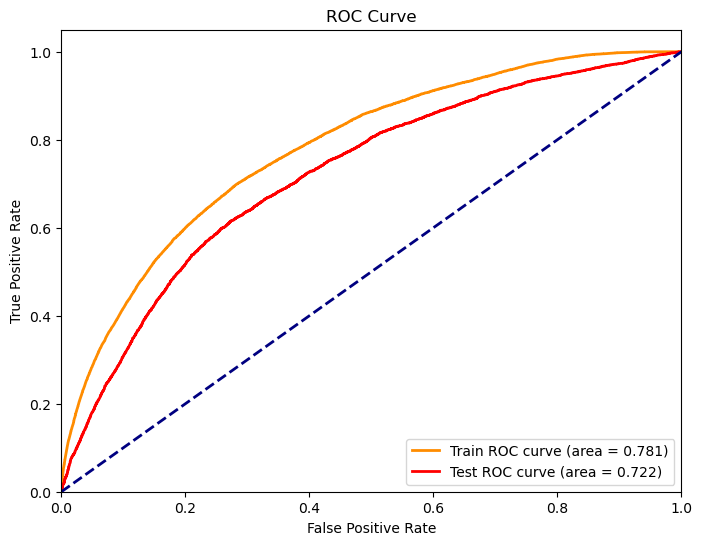

In [73]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2
plt.plot(
    fpr_train,
    tpr_train,
    color="darkorange",
    lw=lw,
    label="Train ROC curve (area = %0.3f)" % roc_auc_train,
)
plt.plot(
    fpr_test,
    tpr_test,
    color="red",
    lw=lw,
    label="Test ROC curve (area = %0.3f)" % roc_auc_test,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

#### Standard Threshold

In [75]:
# standard threshold
thresh=0.5

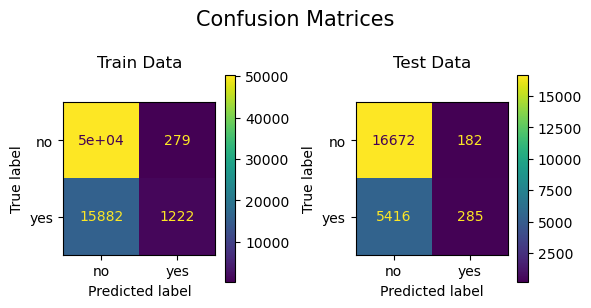

In [70]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred > thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred > thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [71]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

AUC:0.781
balanced accuracy:0.533
accuracy:0.761
recall:0.071
average precision:0.293
specificity:0.994
prevalence:0.253
 


In [72]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

AUC:0.722
balanced accuracy:0.520
accuracy:0.752
recall:0.050
average precision:0.271
specificity:0.989
prevalence:0.253
 


This model has a quite low recall score, which is bad!

#### Threshold Based on Precision-Recall Curve

In [67]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, y_test_pred)

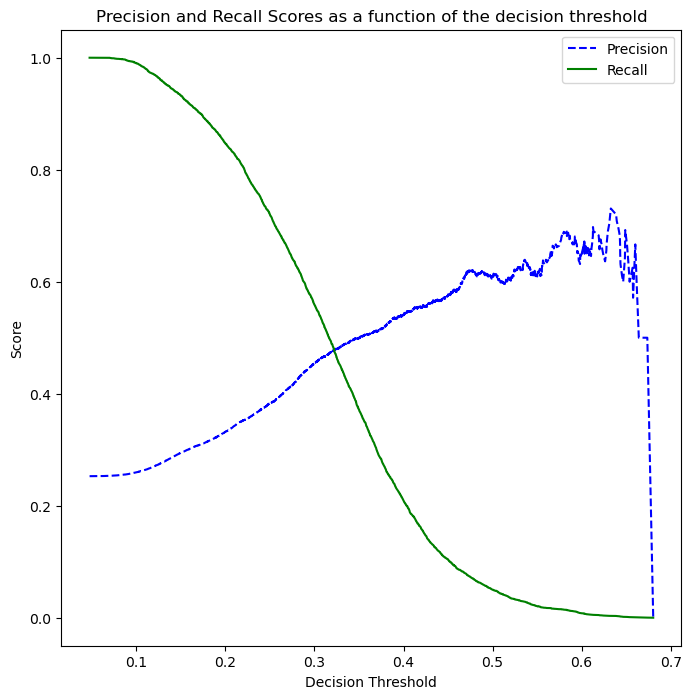

In [68]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [79]:
# set threshold
thresh=0.32

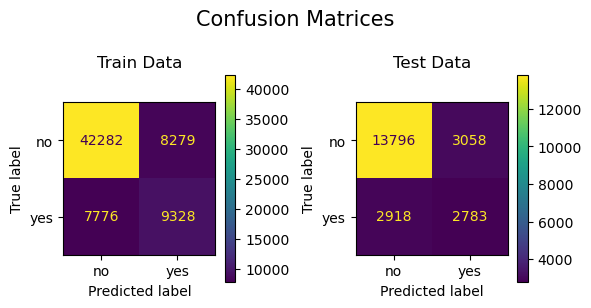

In [80]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred > thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred > thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [81]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

AUC:0.781
balanced accuracy:0.691
accuracy:0.763
recall:0.545
average precision:0.404
specificity:0.836
prevalence:0.253
 


In [82]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

AUC:0.722
balanced accuracy:0.653
accuracy:0.735
recall:0.488
average precision:0.362
specificity:0.819
prevalence:0.253
 


This model has a much better recall score. The average precision score is higher. The specificity is lower, but still high.

In [84]:
# get feature names
feature_names = list(pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out())
feature_names = feature_names + ['dauid','year','month','day']
feature_names

['weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'season_spring',
 'season_summer',
 'season_winter',
 'dauid',
 'year',
 'month',
 'day']

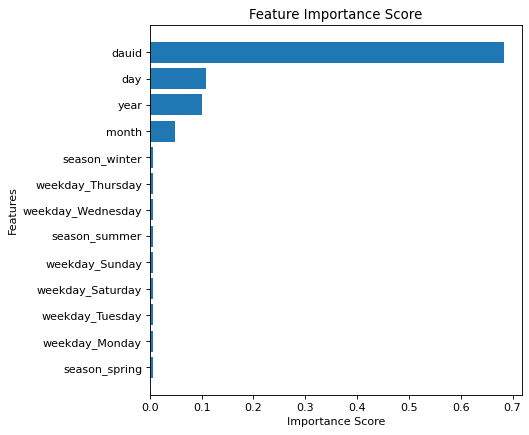

In [86]:
# feature importance

feature_importances = pd.DataFrame(pipe[-1].feature_importances_,
                                   index = feature_names,
                                   columns=['importance']).sort_values('importance', ascending=False)

num = min([50,len(feature_names)])
ylocs = np.arange(num)

# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score')
plt.yticks(ylocs, feature_labels)
plt.show()

`dauid` is the most important feature.
`season` and `weekday` seem to be not important.

### Model 2

With the part_of_day feature.

In [5]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification.csv')
crime_df_full.head()

dauid              neighbourhood        date  year  month  day  \
0  59154181  Central Business District  2019-01-01  2019      1    1   
1  59154181  Central Business District  2019-01-02  2019      1    2   
2  59154181  Central Business District  2019-01-03  2019      1    3   
3  59154181  Central Business District  2019-01-04  2019      1    4   
4  59154181  Central Business District  2019-01-05  2019      1    5   

     weekday  season    part_of_day  crime  
0    Tuesday  winter  early morning      0  
1  Wednesday  winter  early morning      0  
2   Thursday  winter  early morning      0  
3     Friday  winter  early morning      0  
4   Saturday  winter  early morning      0

In [6]:
# data size
crime_df_full.shape

(4480464, 10)

In [7]:
# data types
crime_df_full.dtypes

dauid             int64
neighbourhood    object
date             object
year              int64
month             int64
day               int64
weekday          object
season           object
part_of_day      object
crime             int64
dtype: object

In [8]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
part_of_day              object
crime                     int64
dtype: object

In [9]:
# set target column
target_col = 'crime'

We model on a single neighbourhood. We choose the `Central Business District` as, we saw earlier, it has by far the highest amount of reported crimes.

In [21]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y)

# print their shapes
print(X_train.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_test.shape)

(270660, 7)
(90220, 7)
(270660,)
(90220,)


In [22]:
## define variable types

# nominal variables
nominal_cols = ['weekday','part_of_day','season']

# all variables
all_cols = list(X_train.columns)

In [23]:
# Column transformer for nominal variables: encoded as one-hot numeric arrays.
nominal_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first', sparse=False))
    ]
) 


# combine the column transformer(s)
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_cols),
    ]
)

In [24]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94))
    ]
)


# define hyperparameter search space
param_dict = {'rf__bootstrap': Categorical([True, False]),
              'rf__max_depth': Integer(5,100, prior='uniform'),
              'rf__max_features': Categorical(['auto', 'sqrt']),
              'rf__min_samples_leaf': Integer(1,10, prior='uniform'),
              'rf__min_samples_split': Integer(2,10, prior='uniform'),
              'rf__n_estimators': Integer(200,2000, prior='uniform')}

# Bayesian optimization object
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_dict,
    cv=3,
    scoring='average_precision',
    n_iter=20,
    verbose=4,
    random_state=29
)

# fit on train and tune hyperparemeters
bayes_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END rf__bootstrap=True, rf__max_depth=11, rf__max_features=auto, rf__min_samples_leaf=6, rf__min_samples_split=4, rf__n_estimators=1184;, score=0.106 total time= 1.5min
[CV 2/3] END rf__bootstrap=True, rf__max_depth=11, rf__max_features=auto, rf__min_samples_leaf=6, rf__min_samples_split=4, rf__n_estimators=1184;, score=0.105 total time= 1.4min
[CV 3/3] END rf__bootstrap=True, rf__max_depth=11, rf__max_features=auto, rf__min_samples_leaf=6, rf__min_samples_split=4, rf__n_estimators=1184;, score=0.105 total time= 1.3min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END rf__bootstrap=True, rf__max_depth=70, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=6, rf__n_estimators=932;, score=0.105 total time= 1.0min
[CV 2/3] END rf__bootstrap=True, rf__max_depth=70, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=6, rf__n_estimators=932;, score=0.105 total time= 1

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END rf__bootstrap=True, rf__max_depth=63, rf__max_features=sqrt, rf__min_samples_leaf=10, rf__min_samples_split=2, rf__n_estimators=1487;, score=0.106 total time= 1.6min
[CV 2/3] END rf__bootstrap=True, rf__max_depth=63, rf__max_features=sqrt, rf__min_samples_leaf=10, rf__min_samples_split=2, rf__n_estimators=1487;, score=0.105 total time= 1.6min
[CV 3/3] END rf__bootstrap=True, rf__max_depth=63, rf__max_features=sqrt, rf__min_samples_leaf=10, rf__min_samples_split=2, rf__n_estimators=1487;, score=0.105 total time= 1.6min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END rf__bootstrap=True, rf__max_depth=44, rf__max_features=sqrt, rf__min_samples_leaf=8, rf__min_samples_split=4, rf__n_estimators=996;, score=0.106 total time= 1.1min
[CV 2/3] END rf__bootstrap=True, rf__max_depth=44, rf__max_features=sqrt, rf__min_samples_leaf=8, rf__min_samples_split=4, rf__n_estimators=996;, score=0.105 total time

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('nominal',
                                                                          Pipeline(steps=[('encoder',
                                                                                           OneHotEncoder(drop='first',
                                                                                                         sparse=False))]),
                                                                          ['weekday',
                                                                           'part_of_day',
                                                                           'season'])])),
                                        ('rf',
                                         RandomForestClassifier(n_jobs=7,
                                                                random_state=94))]),
              n_iter=20, random_state=29, scoring='average_precision',
              search_spaces={'rf__boot...
                             'rf__max_depth': Integer(low=5, high=100, prior='uniform', transform='normalize'),
                             'rf__max_features': Categorical(categories=('auto', 'sqrt'), prior=None),
                             'rf__min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'rf__min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'rf__n_estimators': Integer(low=200, high=2000, prior='uniform', transform='normalize')},
              verbose=4)

The score seems to be basically the same low score for all seen combinations. The model is bad.

In [25]:
# average precision score of best_estimator on the left out data
bayes_search.best_score_

0.10550780922923919

In [28]:
# train a model on the entire train set
pipe = pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(n_jobs=7, random_state=94, bootstrap=True, max_depth=7, 
                                     max_features='auto', min_samples_leaf=6, min_samples_split=8, n_estimators=1457))
    ]
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['weekday', 'part_of_day',
                                                   'season'])])),
                ('rf',
                 RandomForestClassifier(max_depth=7, max_features='auto',
                                        min_samples_leaf=6, min_samples_split=8,
                                        n_estimators=1457, n_jobs=7,
                                        random_state=94))])

In [29]:
# predict on train and test set
y_train_pred = pipe.predict_proba(X_train)[:,1]
y_test_pred = pipe.predict_proba(X_test)[:,1]

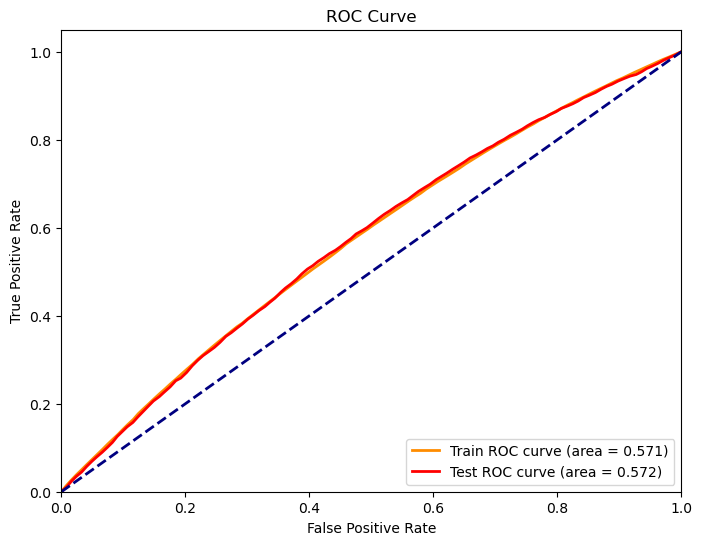

In [43]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2
plt.plot(
    fpr_train,
    tpr_train,
    color="darkorange",
    lw=lw,
    label="Train ROC curve (area = %0.3f)" % roc_auc_train,
)
plt.plot(
    fpr_test,
    tpr_test,
    color="red",
    lw=lw,
    label="Test ROC curve (area = %0.3f)" % roc_auc_test,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [30]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, y_test_pred)

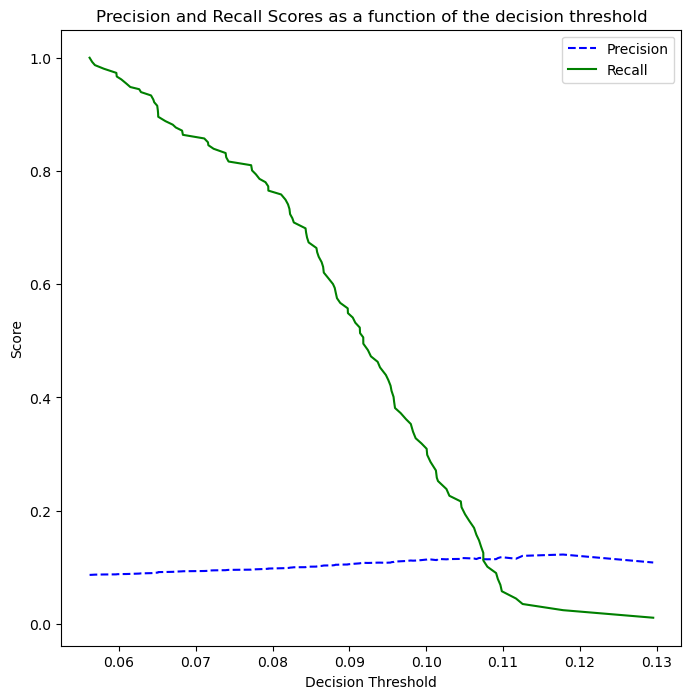

In [31]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [53]:
# set threshold
thresh = 0.106

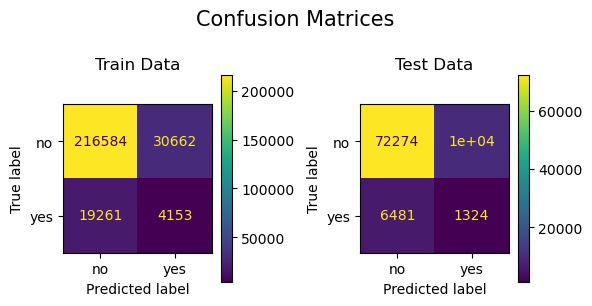

In [54]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (y_train_pred > thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (y_test_pred > thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [55]:
# scores on train data
print_report(y_train, y_train_pred, thresh)

AUC:0.571
balanced accuracy:0.527
accuracy:0.816
recall:0.177
average precision:0.092
specificity:0.876
prevalence:0.087
 


In [56]:
# scores on test data
print_report(y_test, y_test_pred, thresh)

AUC:0.572
balanced accuracy:0.523
accuracy:0.816
recall:0.170
average precision:0.091
specificity:0.877
prevalence:0.087
 


### Model 3

Add census data. Not sure if I have time for this.

In [136]:
census_population = pd.read_csv('data/2021_census_population.csv')
census_population.head()

Geographic name Population, 2021 Total private dwellings, 2021  \
0            Canada 2       36,991,981                    16,284,235   
1  British Columbia 2        5,000,879                     2,211,694   
2           Vancouver          662,248                       328,347   
3            59150307              677                           297   
4            59150308              541                           229   

  Private dwellings occupied by usual residents, 2021  \
0                                         14,978,941    
1                                          2,041,834    
2                                            305,336    
3                                                266    
4                                                218    

  Land area in square kilometres, 2021  \
0                         8,788,702.80   
1                           920,686.55   
2                               115.18   
3                                  0.3   
4                                 0.11   

  Population density per square kilometre, 2021  
0                                           4.2  
1                                           5.4  
2                                      5,749.90  
3                                      2,263.50  
4                                      4,936.10

In [137]:
census_population.drop([0, 1, 2], inplace=True)
census_population.head()

Geographic name Population, 2021 Total private dwellings, 2021  \
3        59150307              677                           297   
4        59150308              541                           229   
5        59150309              761                           299   
6        59150310              748                           411   
7        59150311              537                           202   

  Private dwellings occupied by usual residents, 2021  \
3                                                266    
4                                                218    
5                                                282    
6                                                389    
7                                                187    

  Land area in square kilometres, 2021  \
3                                  0.3   
4                                 0.11   
5                                 0.11   
6                                 0.11   
7                                 0.08   

  Population density per square kilometre, 2021  
3                                      2,263.50  
4                                      4,936.10  
5                                      6,800.70  
6                                      6,837.30  
7                                      6,637.80

In [157]:
census_population[census_population['Geographic name']==59150308]['Population, 2021'].values[0]

541

In [138]:
census_population.dtypes

Geographic name                                        object
Population, 2021                                       object
Total private dwellings, 2021                          object
Private dwellings occupied by usual residents, 2021    object
Land area in square kilometres, 2021                   object
Population density per square kilometre, 2021          object
dtype: object

In [156]:
census_population['Geographic name'] = census_population['Geographic name'].astype('int64')
census_population['Population, 2021'] = census_population['Population, 2021'].str.replace(',','').astype('int64')
census_population['Total private dwellings, 2021'] = census_population['Total private dwellings, 2021'].str.replace(',','').astype('int64')
census_population['Private dwellings occupied by usual residents, 2021'] = census_population['Private dwellings occupied by usual residents, 2021'].str.replace(',','').astype('int64')
census_population['Land area in square kilometres, 2021'] = census_population['Land area in square kilometres, 2021'].str.replace(',','').astype('float64')
census_population['Population density per square kilometre, 2021'] = census_population['Population density per square kilometre, 2021'].str.replace(',','').astype('float64')
census_population.dtypes

Geographic name                                          int64
Population, 2021                                         int64
Total private dwellings, 2021                            int64
Private dwellings occupied by usual residents, 2021      int64
Land area in square kilometres, 2021                   float64
Population density per square kilometre, 2021          float64
dtype: object

In [147]:
census_population.groupby('Geographic name')['Population, 2021'].count().sort_values(ascending=False)

Geographic name
59150307    1
59152944    1
59151474    1
59151475    1
59151476    1
           ..
59150686    1
59150687    1
59150688    1
59150689    1
59154196    1
Name: Population, 2021, Length: 1016, dtype: int64

In [158]:
census_population.head()

Geographic name  Population, 2021  Total private dwellings, 2021  \
3         59150307               677                            297   
4         59150308               541                            229   
5         59150309               761                            299   
6         59150310               748                            411   
7         59150311               537                            202   

   Private dwellings occupied by usual residents, 2021  \
3                                                266     
4                                                218     
5                                                282     
6                                                389     
7                                                187     

   Land area in square kilometres, 2021  \
3                                  0.30   
4                                  0.11   
5                                  0.11   
6                                  0.11   
7                                  0.08   

   Population density per square kilometre, 2021  
3                                         2263.5  
4                                         4936.1  
5                                         6800.7  
6                                         6837.3  
7                                         6637.8

In [ ]:
crime_df_full['population'] = np.nan
crime_df_full['priv_dwellings'] = np.nan
crime_df_full['priv_dwellings_res'] = np.nan
crime_df_full['sqkm'] = np.nan
crime_df_full['population_sqkm'] = np.nan

# add census data
for my_id in census_population['Geographic name'].unique():
    crime_df_full.loc[crime_df_full['dauid']==my_id, 'population'] = census_population[census_population['Geographic name']==my_id]['Population, 2021'].values[0]
    crime_df_full.loc[crime_df_full['dauid']==my_id, 'priv_dwellings'] = census_population[census_population['Geographic name']==my_id]['Total private dwellings, 2021'].values[0]
    crime_df_full.loc[crime_df_full['dauid']==my_id, 'priv_dwellings_res'] = census_population[census_population['Geographic name']==my_id]['Private dwellings occupied by usual residents, 2021'].values[0]
    crime_df_full.loc[crime_df_full['dauid']==my_id, 'sqkm'] = census_population[census_population['Geographic name']==my_id]['Land area in square kilometres, 2021'].values[0]
    crime_df_full.loc[crime_df_full['dauid']==my_id, 'population_sqkm'] = census_population[census_population['Geographic name']==my_id]['Population density per square kilometre, 2021'].values[0]

In [ ]:
census_population_2 = pd.read_csv('data/98100129-eng/98100129.csv')
census_population_2 = census_population_2[census_population_2['GEO'].str.startswith('5915')]
census_population_2.head()

## Cynet

Via [Cynet](https://pypi.org/project/cynet/). I will likely have no time for this.

## Results

**EDA**

- The total number of crimes has a decreasing trend over the years.
- `Theft from Vehicle` and `Other Theft` are the most common reported crimes in Vancouver.
- `Homicide` and `Vehicle Collision or Pedestrian Struck (with Fatality)` are the least common crimes.
- `Central Business District` has by far the highest amount of reported crimes, whereas `Musqueam` has the lowest amount of reported crimes.
- `Theft of Vehicle` has the best improvement since 2003, followed by `Break and Enter Residential/Other`.
- `Theft of Bicycle` has the worst development since 2003.
- Crimes occur throughout the year.
- Summer has the highest amount of criminal activities, while winter has the lowest.
- Most of the crimes occur on Fridays and Saturdays, while the least amount of crimes occurs during the middle of the week.
- Most crimes occur from 12pm to 1am, with an exceptional peak at midnight. There is a significant drop of crimes from 12am to 1am. Crimes stay relatively low from 1am to 7am. Crimes are drastically reported around 8am and gradually increase throughout the day peaking at 6pm. In between, we have a smaller peak at noon.



**Prediction**

- We choose to predict crime in the `Central Business District` as it has by far the highest amount of reported crimes.
- Random Forest with the best parameters yields the following scores on the test set:
    - AUC: 0.722
    - Balanced accuracy: 0.653
    - Accuracy: 0.735
    - Recall: 0.488
    - Average precision: 0.362
    - Specificity: 0.819
- The dissemination block is the most important feature. Season and weekday seem not to be important.

## Next Steps
In the future, we plan to:
- use time series analysis to determine long-term changes and seasonal components of crime
- incorporate the location of [police stations](https://vpd.ca/community/community-policing-centres/)
- analyze the relationship between demographic, social, and economic neighborhood characteristics and the spatial distribution of crime
- apply the [Cynet model](https://pypi.org/project/cynet/)